# Forest estate modelling input data prep (BC RIA landbase)

This notebook (and everything else in this project) was designed and implemented by Gregory Paradis (gregory.paradis@ubc.ca).

This notebook implements a data processing pipeline to prepare input datasets for the landscape-level forest estate modelling (e.g., ws3, SpaDES, Patchworks, etc.) for timber supply areas (TSAs) in British Columbia (BC).

This notebook imports various publicly-available vegetation resource inventory (VRI) datasets, extracts the RIA landbase subset, stratifies features in a way that can work for the harvesting and carbon analyses we are planning, and builds VDYP and TIPSY yield curves.

The source datasets are all freely available, but need to be downloaded and unpacked to paths that match the paths specified further down in the notebook (or modify the path parameter values). We list links to datasets used below.

This algorithms and input data files in this project are custom built to compile input data for computational experiments on a cluster of five TSAs in the north-east corner of BC (i.e., TSAs 08, 16, 24, 40, 41). However, our intention while building this prototype was to make this tool generic and modular enough to be re-usable (to a large extent) for any (or all!) TSAs in BC. In other words, copying this project and adapting it to work with other TSAs is likely a _much_ better idea than starting from scratch. Later, we our intent is to extend this work until it includes reasonable default turn-key behaviour for _all_ TSAs in BC---this should make greatly reduce the cost and difficulty of compiling inventory and yield curve datasets to be used as input for new forest estate models of public TSAs in BC. 

## Datasets

Links to source datasets used in this notebook.

[FADM - Timber Supply Area (TSA)](https://catalogue.data.gov.bc.ca/dataset/8daa29da-d7f4-401c-83ae-d962e3a28980)

[VRI - 2019 - Forest Vegetation Composite Rank 1 Layer (R1)](https://catalogue.data.gov.bc.ca/dataset/2ebb35d8-c82f-4a17-9c96-612ac3532d55)

[VRI - 2019 - Variable Density Yield Projection 7 (VDYP7) Input Polygon](https://catalogue.data.gov.bc.ca/dataset/57513aaa-c0a6-41a9-b2a8-b980b1604ee6)

[Site Productivity - Site Index by Tree Species](https://catalogue.data.gov.bc.ca/dataset/04ad45c3-0fdc-4506-bdb4-252c45a63459)

[Generalized Forest Cover Ownership](https://catalogue.data.gov.bc.ca/dataset/5fc4e8ce-dd1d-44fd-af17-e0789cf65e4ehttps://catalogue.data.gov.bc.ca/dataset/5fc4e8ce-dd1d-44fd-af17-e0789cf65e4e)

See also [VRI code lists](https://www.for.gov.bc.ca/hfp/publications/00026/fs708-14-appendix_d.htm) for some metadata that can help you decode and understand some of the datasets we use.

## Software dependencies

Python packages imported below must be installed. We also use a [patched branch](https://github.com/gparadis/ArcRasterRescue/tree/bug-fix_transform) of the ArcRasterRescue package to export species-wise site productivity raster data layers from the proprietary ESRI File Geodatabase file.

Also check this out for BC raster data:

https://hectaresbc.ca/app/habc/HaBC.html

Clone the correct branch of the ArcRasterRescue repository from GitHub, and compile the executable.

Import required packages.

In [1]:
import os
import matplotlib.pyplot as plt
import datatable
import pandas as pd
import geopandas as gpd
import pickle
import seaborn as sns
from shapely.ops import unary_union, Polygon
import numpy as np
from numpy.polynomial import Polynomial
import csv
from scipy.optimize import curve_fit
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.io import MemoryFile
from geocube.api.core import make_geocube
import subprocess
import shlex
from rasterio.plot import show, show_hist
import warnings
from pympler import asizeof
import ipcmagic
import ipyparallel as ipp
import mapply
import swifter
import fiona
import affine
from osgeo import gdal
import glob
import operator
import distance
from scipy.optimize import curve_fit as _curve_fit
from functools import partial, wraps
import itertools

Set global notebook parameters.

In [2]:
pd.set_option('display.max_rows', 300) # bump this parameter up if you want to see more table rows
pd.set_option('display.max_columns', 30) # bump this parameter up if you want to see more table rows

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
%config Completer.use_jedi = False # patch autocomplete bug

Launch and set up `ipyparallel` cluster on the VM. We will deploy parallel processing jobs to this cluster at various stages in the process to speed up processing (take advantage of 16 cores available on the host).

In [3]:
#%ipcluster --help
%ipcluster start -n 16
rc = ipp.Client()
lbview = rc.load_balanced_view()

IPCluster is ready! (5 seconds)


Define path strings and such.

In [4]:
vri_vclr1p_path = '../data/bc/vri/2019/VEG_COMP_LYR_R1_POLY.gdb'
ria_stands_path = './data/veg_comp_lyr_r1_poly-ria.shp'
tsa_boundaries_path = '../data/bc/tsa/FADM_TSA.gdb/'
ria_maptiles_path = 'ria_maptiles.csv'
vdyp_input_pandl_path = './data/VEG_COMP_VDYP7_INPUT_POLY_AND_LAYER_2019.gdb'

site_prod_bc_gdb_path = './data/Site_Prod_BC.gdb/' # ESRI File Geodatabase containing 22 species-wise site productivity raster layers

tsa_boundaries_feather_path = './data/tsa_boundaries.feather'
ria_vri_vclr1p_checkpoint1_feather_path = './data/ria_vri_vclr1p_checkpoint1.feather'
ria_vri_vclr1p_checkpoint2_feather_path = './data/ria_vri_vclr1p_checkpoint2.feather'
ria_vri_vclr1p_checkpoint3_feather_path = './data/ria_vri_vclr1p_checkpoint3.feather'
ria_vri_vclr1p_checkpoint4_feather_path = './data/ria_vri_vclr1p_checkpoint4.feather'
ria_vri_vclr1p_checkpoint5_feather_path = './data/ria_vri_vclr1p_checkpoint5.feather'
ria_vri_vclr1p_checkpoint6_feather_path = './data/ria_vri_vclr1p_checkpoint6.feather'
ria_vri_vclr1p_checkpoint7_feather_path = './data/ria_vri_vclr1p_checkpoint7.feather'
ria_vri_vclr1p_checkpoint8_feather_path = './data/ria_vri_vclr1p_checkpoint8.feather'
vri_vclr1p_categorical_columns_path = './data/vri_vclr1p_categorical_columns'
ria_vclr1p_feature_tif_path = './data/ria_vclr1p_feature_raster.tif'

arc_raster_rescue_exe_path = '../ArcRasterRescue/build/arc_raster_rescue.exe'
siteprod_gdb_path = './data/Site_Prod_BC.gdb/'
siteprod_tmpexport_tif_path_prefix = './data/site_prod_bc_'
siteprod_tif_path = './data/siteprod.tif'

vdyp_ply_feather_path = './data/vdyp_ply.feather'
vdyp_lyr_feather_path = './data/vdyp_lyr.feather'
vdyp_results_tsa_pickle_path_prefix = './data/vdyp_results-tsa'
vdyp_results_pickle_path = './data/vdyp_results.pkl'
vdyp_curves_smooth_tsa_feather_path_prefix = './data/vdyp_curves_smooth-tsa'
vdyp_curves_smooth_feather_path = './data/vdyp_curves_smooth.feather'

tipsy_params_path_prefix = './data/tipsy_params_tsa'

ria_tsas = ['08', '16', '24', '40', '41']
si_levels = ['L', 'M', 'H']

raster_pxw = raster_pxh = 100

tipsy_params_columns = [line.strip() for line in open('./data/tipsy_params_columns').readlines()]

Define lists grouping species codes by genus.

In [5]:
species_spruce = ['S', 'SB', 'SE', 'SN', 'SS', 'SW', 'SX', 'SXE', 'SXL', 'SXW']
species_pine = ['P', 'PA', 'PJ', 'PL', 'PLC', 'PLI', 'PM']
species_fir = ['B', 'BA', 'BB', 'BG', 'BL', 'BM', 'BP']
species_larch = ['L', 'LA', 'LS', 'LT', 'LW']
species_cedar = ['C', 'CW']
species_hemlock = ['HM', 'HWI', 'HW']
species_douglasfir = ['F', 'FD', 'FDC', 'FDI']

species_aspen = ['AC', 'ACB', 'ACT', 'AD', 'AT', 'AX']
species_birch = ['E', 'EA', 'EB', 'EE', 'EP', 'EW', 'EXP']
species_willow = ['W','WA', 'WB', 'WD', 'WP', 'WS']
species_alder = ['D', 'DR']
species_cherry = ['V']
species_dogwood = ['GP']
species_oak = ['Q']
species_maple = ['M', 'MB', 'MV']

Download and compile ArcRasterRescue package. We will use this later to extract raster data from proprietary ESRI File Geodatabase.

In [6]:
if not os.path.isfile(arc_raster_rescue_exe_path):
    !git clone https://github.com/gparadis/ArcRasterRescue.git
    !cd ArcRasterRescue; git checkout bug-fix_transform
    !mkdir ArcRasterRescue/build
    !cd ArcRasterRescue/build; cmake -DCMAKE_BUILD_TYPE=RelWithDebInfo ..; make

Load TSA boundary data for the 5 TSAs in the RIA landbase (TSAs 08, 16, 24, 40, 41) and compile a single polygon defining RIA landbase extent. We simplify the boundary geometry for each TSA (preserving topology). Cache a copy of result to a feather file (can later be imported to speed up processing).

In [7]:
import_tsa_boundaries_data = 0
if import_tsa_boundaries_data:
    tsa_boundaries = gpd.read_file(tsa_boundaries_path)
    tsa_boundaries = tsa_boundaries[['TSA_NUMBER', 'geometry']].loc[tsa_boundaries.TSA_NUMBER.isin(ria_tsas)].dissolve(by='TSA_NUMBER')
    tsa_boundaries['geometry'] = tsa_boundaries.geometry.simplify(tolerance=1000, preserve_topology=True)
    tsa_boundaries.to_feather(tsa_boundaries_feather_path)
else:
    tsa_boundaries = gpd.read_feather(tsa_boundaries_feather_path)

#tsa_extent_all = Polygon(unary_union(list(tsa_boundaries.geometry.values)).exterior) 

Load VRI features (_vegetation composite layer and R1 polygon_ dataset), masked to RIA landbase extent. Cache a copy of result to a feather file (can later be imported to speed up processing).

In [8]:
%%time
import_vri_vclr1p_data = 0 # set to False to use cached data 
if import_vri_vclr1p_data:
    print('loading VRI data from source')
    def load_vri_vclr1p(vri_vclr1p_path, tsa_code, tsa_mask, ignore_geometry=False):
        import geopandas as gpd # local import required to play nice with ipp engines
        result = gpd.read_file(vri_vclr1p_path, 
                               mask=tsa_mask,
                               ignore_geometry=ignore_geometry)
        result['tsa_code'] = tsa_code
        return result
    tsa_gdfs = lbview.map_async(load_vri_vclr1p, 
                                [vri_vclr1p_path for tsa in ria_tsas],
                                ria_tsas, 
                                [tsa_boundaries.loc[tsa].geometry for tsa in ria_tsas],
                                ordered=True)
    rc.wait_interactive()
    ria_vri_vclr1p = pd.concat(tsa_gdfs, axis=0, ignore_index=True)
    ria_vri_vclr1p.to_feather(ria_vri_vclr1p_checkpoint1_feather_path)
else:
    print('loading VRI data from checkpoint1 feather')
    ria_vri_vclr1p = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

f = ria_vri_vclr1p

loading VRI data from checkpoint1 feather
CPU times: user 1min 21s, sys: 19.1 s, total: 1min 40s
Wall time: 1min 36s


Extract site productivity raster data from proprietary ESRI File Geodatabase, and export it to species-wise GeoTIFF layers, patch the missing CRS metadata, and stack everything into a single multi-band GeoTIFF. 

In [9]:
# map layer indices to layer species codes
result = subprocess.run(shlex.split('%s %s' % (arc_raster_rescue_exe_path, siteprod_gdb_path)), capture_output=True)
siteprod_layerspecies =  {int(i):vv[10:].upper() 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}
siteprod_specieslayer =  {vv[10:].upper():int(i) 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}

if not os.path.isfile(siteprod_tif_path):
    # export species-wise raster layers to 22 GeoTIFFs
    print('Extracting siteprod raster data from ESRI File Geodatabase...')
    for i, species in site_prod_bc_layerspecies.items():
        print('... processing species', species)
        args = '%s %s %i %s' % (arc_raster_rescue_exe_path, 
                                site_prod_bc_gdb_path, 
                                i, 
                                '%s%s.tif' % (siteprod_tmpexport_tif_path_prefix, species))
        subprocess.run(shlex.split(args))

    # stack species-wise raster layers into a single multi-band GeoTIFF
    file_list = sorted(glob.glob('%s*.tif' % siteprod_tmpexport_tif_path_prefix))
    with rio.open(file_list[0]) as src: # patch with missing CRS metadata
        meta = src.meta
        meta.update(count=len(file_list), 
                    compress='lzw', 
                    crs=rio.crs.CRS({"init": "epsg:3005"})) # BC Albers equal area geographic projection

    with rio.open(siteprod_tif_path, 'w', **meta) as dst:
        print('\nStacking siteprod raster data into a single multiband GeoTIFF file...')
        for id, layer in enumerate(file_list, start=1):
            print('... processing species', siteprod_layerspecies[id-1])
            with rio.open(layer) as src:
                dst.write_band(id, src.read(1))
            os.remove(layer) # delete intermediate GeoTIFF (not needed anymore)

Define a species code lookup dict to map VRI species codes to one of the 22 siteprod species codes. We built the key list for this dict by compiling unique values from the `SPECIES_CD_1` column in the VRI feature dataset, and netting out the 22 siteprod species codes. Assignments with question mark comments may need to be revisited. If this project is ported to a different landbase, this list would likely need to be expanded (we can eventually just build a BC-wide species code map from the unfiltered VRI dataset).

In [10]:
def siteprod_species_lookup(s):
    spp = {'AC': 'AT',
           'PLI': 'PL',
           'FDI': 'FD',
           'S': 'SW',
           'SXL': 'SX',
           'ACT': 'AT',
           'E': 'EP',
           'P': 'PL',
           'EA': 'EP',
           'SXW': 'SX',
           'W': 'EP', # ?
           'T': 'LT', # ?
           'L': 'LT',
           'B': 'BL',
           'ACB': 'AT',
           'PJ': 'PL', # ?
           'WS': 'EP',
           'LA':'LT',
           'AX':'AT',
           'BB':'BL',
           'H':'HW', 
           'BM':'BL',
           'V':'DR',
           'F':'FD',
           'C':'CW',
           'XC':'PL',
           'XD':'SW',
           'X':'SW',
           'A':'AT',
           'D':'DR',
           'Z':'SW',
           'Q':'AT',
           'Y':'YC',
           'R':'DR',
           'G':'DR'} # ?
    try:
        result = spp[s]
    except:
        try:
            result = spp[s[0]]
        except:
            print(s)
            assert False # bad species code
    return result
    
species_list = list(set().union(*[ria_vri_vclr1p['SPECIES_CD_%i' % i].unique() for i in range(1, 7)]))
species_list = [s for s in species_list if s is not None]

Clean and filter VRI feature dataset. This includes replacing null data values in certain columns with specific non-null values ('X' or 0, depending on field type) to ensure that data processing logic works correctly in downstream steps. 

In earlier versions of this code we cast some columns to `category` data type (in an attempt to reduce memory footprint and maybe speeds up some processing), but this proved to be more trouble than it was worth and that code is commented out in the current version.

Then, for each feature in the VRI dataaset, extract mean SI data from the pixels in the siteprod raster layer corresponding the leading species. This step is computationally intensive (takes about 30 minutes to run), so this is a good time to go for a walk.

Cache a copy of result to a feather file (can later be imported to speed up processing).

In [11]:
process_checkpoint2 = 0
if process_checkpoint2:
    for i in range(1, 7):
        f['SPECIES_CD_%i' % i].fillna('X', inplace=True)
        f['SPECIES_PCT_%i' % i].fillna(0, inplace=True)
    f['SOIL_NUTRIENT_REGIME'].fillna('X', inplace=True)
    f['SOIL_MOISTURE_REGIME_1'].fillna('X', inplace=True)
    f['SITE_POSITION_MESO'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_3'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_4'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_5'].fillna('X', inplace=True)
    f['BEC_VARIANT'].fillna('X', inplace=True)
    f['LIVE_STAND_VOLUME_125'].fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP1_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP2_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP3_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP4_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP5_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP6_125.fillna(0, inplace=True)
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.BCLCS_LEVEL_5 != 'OP']
    f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[f.PROJ_AGE_1 >= 30]
    f = f[f.BASAL_AREA >= 5]
    f = f[f.LIVE_STAND_VOLUME_125 >= 1]
    f.shape
    #vri_vclr1p_categorical_columns = open(vri_vclr1p_categorical_columns_path).read().split('\n')
    #for c in vri_vclr1p_categorical_columns: 
    #    f[c] = f[c].astype('category')
    with rio.open(siteprod_tif_path) as src:
        def mean_siteprod(r):
            a, _ = mask(src, r.geometry, crop=True)
            s = r.SPECIES_CD_1 
            s = s if s in siteprod_specieslayer else siteprod_species_lookup(s)
            i = siteprod_specieslayer[s]
            aa = a[i]
            return np.mean(aa[aa > 0])
        f['siteprod'] = f.swifter.apply(mean_siteprod, axis=1)
    f.to_feather(ria_vri_vclr1p_checkpoint2_feather_path)
else:
    print('loading VRI data from checkpoint2 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint2_feather_path)

loading VRI data from checkpoint2 feather


VRI data includes merchantable growing stock (per ha) and species codes for the top 7 species in each stand. We recompile the volume data into species-wise columns (using species codes from `species_list`, defined earlier). This makes the table bigger (lots of null values, as only up to 7 species volume columns will have data), but makes the processing logic simpler and more stable later on.

Cache a copy of result to a feather file (can later be imported to speed up processing).

In [12]:
f.reset_index(inplace=True)

In [13]:
process_checkpoint3 = 1
if process_checkpoint3:
    def compile_species_vol(df, species):
        import swifter
        return df.swifter.apply(lambda r: sum(r['LIVE_VOL_PER_HA_SPP%i_125' % i] 
                                              for i in range(1, 7)
                                              if r['SPECIES_CD_%i' % i] == species), axis=1)
    cols = list(itertools.chain.from_iterable(['LIVE_VOL_PER_HA_SPP%i_125' % i]+['SPECIES_CD_%i' % i] for i in range(1, 7)))    
    f_ = f[cols]
    result = lbview.map_async(compile_species_vol, 
                              [f_]*len(species_list), 
                              species_list, 
                              ordered=True)
    rc.wait_interactive()
    
    for i, species in enumerate(species_list):
        print('compiling species', species)
        f['live_vol_per_ha_125_%s' % species] = result[i]
    f.to_feather(ria_vri_vclr1p_checkpoint3_feather_path)
else:
    print('loading VRI data from checkpoint3 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint3_feather_path)

  10/10 tasks finished after   68 s
done
compiling species SN
compiling species BM
compiling species HM
compiling species RA
compiling species BB
compiling species AT
compiling species B
compiling species FDI
compiling species EP
compiling species P
compiling species WP
compiling species PJ
compiling species AX
compiling species LT
compiling species SW
compiling species SS
compiling species ACT
compiling species E
compiling species TW
compiling species GP
compiling species HW
compiling species AC
compiling species CW
compiling species C
compiling species WD
compiling species T
compiling species ACB
compiling species SXL
compiling species Z
compiling species WB
compiling species WA
compiling species FD
compiling species XC
compiling species PM
compiling species PLI
compiling species YC
compiling species SXW
compiling species PA
compiling species BG
compiling species PR
compiling species L
compiling species EW
compiling species SE
compiling species PL
compiling species BP
compiling speci

Define some utility functions that we will use later to classify VRI records.

In [14]:
def is_conif(species_code):
    # return True if species_code is coniferous species
    return species_code[:1] in ['B', 'C', 'F', 'H', 'J', 'L', 'P', 'S', 'T', 'Y']


def is_decid(species_code):
    # return True if species_code is deciduous species
    return species_code[:1] in ['A', 'D', 'E', 'G', 'M', 'Q', 'R', 'U', 'V', 'W']


def pconif(r):
    # return proportion of volume from coniferous species in record r
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_conif(r['SPECIES_CD_%i' % i])) / 100.


def pdecid(r):
    # return proportion of volume from deciduous species in record r
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_decid(r['SPECIES_CD_%i' % i])) / 100.
    

def classify_stand_cdm(r):
    # Classify stand (from VRI record r) as one of: conif (c), decid (d), or mixed (m), where
    #   c >= 80% softwood
    #   d >= 80% hardwood
    #   m otherwise
    if pconif(r) >= 0.8:
        return 'c'
    elif pdecid(r) >= 0.8:
        return 'd'
    else:
        return 'm'
    
def classify_stand_forest_type(r):
    # to (approximately) match TSA 41 TSR data package AU regeneration logic
    if pconif(r) >= 0.75:
        return 1 # pure conif
    elif pconif(r) >= 0.50:
        return 2 # conif mix
    elif pconif(r) >= 0.25:
        return 3 # decid mix
    else:
        return 4 # pure decid

Next we define a function to generate stratum codes for a given VRI record `r`. 

In standard (not lexmatch) mode, this function will generate a stratum code string including BEC zone code, leading species code, and secondary species code (if classified as a mixedwood stand according to BCLCS codes). 

In lexmatch mode, this will generate a longer stratum code string intended for lexicographic matching (used later with a clustering algorithm that finds "best match" strata based on these codes. Stratum code strings are built from the same data, but use special "lexmatch" versions of the data fields where data values have enhanced. Lexmatch field values are recompiled to a fixed width (padded with `x` character), and in the case of (primary, secondary, tertiary) species code fields the first charater (representing genus, sort of) is duplicated. These lexmatch field values are repeated (3 times for the BEC zone code, 2 times for the primary species code) within the lexmatch stratum codes to influence the relative importance of different components during matching. 

Note that we tested several alternative stratum code formulations before settling on this one, which yielded consistently good results across all 5 TSAs in the study area. In searching for a "good" stratification scheme, we were looking for relatively tight SI distribution within each stratum (indicating that the aggregated sites have a similar growth potential) and a high proportion of total area coverage in the top 15 or so strata within a given TSA (indicating that we can compile growth and yield curves for a relatively small number of strata while still covering most of the forest).   

In [15]:
def stratify_stand(r, lexmatch=False, lexmatch_fieldname_suffix='_lexmatch'):
    result = ''
    if lexmatch:
        result += 3 * r['BEC_ZONE_CODE%s' % lexmatch_fieldname_suffix]
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += 2 * r['SPECIES_CD_1%s' % lexmatch_fieldname_suffix]
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r['SPECIES_CD_2%s' % lexmatch_fieldname_suffix]
    else:
        result += r.BEC_ZONE_CODE
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += r.SPECIES_CD_1
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r.SPECIES_CD_2
    return result

Compile enhanced lexmatch fields as described above, and use the `stratify_stands` function to compile `stratum` and `stratum_lexmatch` columns.  We use the `swifter` version of the `apply` method here, which will attempt to automatically parallelize processing.

In [16]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

Pandas Apply:   0%|          | 0/1224701 [00:00<?, ?it/s]

In [17]:
stratum_col = 'stratum'

Compile `forest_type` column (1: softwood, 2: softwood mix, 3: hardwood mix, 4: hardwood).

In [18]:
#f['forest_type'] = f.reset_index().swifter.apply(classify_stand_forest_type, axis=1)
f['forest_type'] = f.apply(classify_stand_forest_type, axis=1)

Save checkpoint 4 stand dataframe to feather file.

In [19]:
f.to_feather(ria_vri_vclr1p_checkpoint4_feather_path)

In [20]:
if 0: # roll back if screwed up further down
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint4_feather_path)

We are done with inventory data pre-processing now. In the next part of the procedure, we define strata and analysis units (AUs) within each TSA, and generate VDYP and TIPSY yield curves for each AU. 

# Compile strata, AUs, and yield curves for each TSA

In [21]:
#f = f.reset_index().set_index('tsa_code')

Define some empty dicts to store various outputs from the following steps.

In [22]:
vdyp_curves_smooth = {}
vdyp_results = {}
tipsy_params = {}
tipsy_curves = {}
scsi_au = {}
au_scsi = {}
results = {}

In [23]:
if 0:
    def process_vdyp_out(vdyp_out, volume_flavour='Vdwb', min_age=30, max_age=300, 
                         sigma_c1=10, sigma_c2=0.4, dx_c1=0.5, dx_c2=10,
                         window=10,  skip1=0, skip2=30, maxfev=100000,
                         body_fit_func=body_fit_func, body_fit_func_bounds_func=body_fit_func_bounds_func,
                         toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func):
        vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
        c = vdyp_out_concat.groupby(level='Age')[volume_flavour].median()
        c = c[c > 0]
        c = c[c.index >= min_age]
        x = c.index.values
        y = c.rolling(window=window, center=True).median().values
        x, y = x[y > 0], y[y > 0]
        x, y = x[skip1:], y[skip1:]
        #return x, y
        y_mai = pd.Series(y / x, x)
        y_mai_max_age = y_mai.idxmax()
        sigma = (np.abs(x - y_mai_max_age) + sigma_c1)**sigma_c2
        popt, pcov = curve_fit(body_fit_func, x, y, bounds=body_fit_func_bounds_func(x), maxfev=maxfev, sigma=sigma)
        x = np.array(range(1, max_age))
        y = fit_func1(x, *popt)
        dx = max(0, dx_c1 * popt[2] - dx_c2)
        print(dx, dx_c1, popt[2], dx_c2)
        x, y, (i1, popt_toe) = fill_curve_left(x, y, skip=skip2, dx=dx, maxfev=maxfev,
                                               toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func)
        print(popt_toe)
        return x, y

Define some keyword argument override values, to fine-tune curve generation for a few difficult AUs. Most AUs get processed without problems using default parameters. We found these special cases after visually inspecting output curves using default parameters, and determined the custom parameters values through "expert tuning".

In [24]:
kwarg_overrides = {'08':{('BWBS_SB', 'H'):{'skip1':30},
                         ('BWBS_S', 'L'):{'skip1':50},
                         ('SWB_S', 'L'):{'skip1':30},
                         ('BWBS_AT', 'H'):{'skip1':30}},
                   '16':{('SWB_SX', 'L'):{'skip1':30}},
                   '24':{('ESSF_BL', 'L'):{'skip1':30}},
                   '40':{('BWBS_SX', 'L'):{'skip1':30},
                         ('SWB_SX', 'L'):{'skip1':60, 'dx_c1':1., 'dx_c2':0.}},
                   '41':{('ESSF_BL', 'L'):{'skip1':60},
                         ('ESSF_SE', 'M'):{'skip1':30}}}

In [25]:
if 0:
    tsa = '41'
    vdyp_curves_smooth_tsa_feather_path = '%s%s.feather' % (vdyp_curves_smooth_tsa_feather_path_prefix, tsa)
    #if not os.path.isfile(vdyp_curves_smooth_tsa_feather_path):
    if 1:
        figsize = (8, 6)
        plot = 1
        vdyp_smoothxy = {}
        palette_flavours=['RdPu', 'Blues', 'Greens', 'Greys']
        palette = sns.color_palette('Greens', 3)
        sns.set_palette(palette)
        alphas = [1.0, 0.5, 0.1]
        for stratumi, sc, result in results[tsa]:
            if sc != 'ESSF_SE': continue
            if plot: fig, ax = plt.subplots(1, 1, figsize=figsize)
            print('stratum',stratumi, sc)
            #for i, si_level in enumerate(si_levels):
            for i, si_level in enumerate(['M']):            
                print('processing', sc, si_level)
                vdyp_out = vdyp_results[tsa][stratumi][si_level]
                kwargs = {}
                if (sc, si_level) in kwarg_overrides[tsa]:
                    kwargs.update(kwarg_overrides[tsa][(sc, si_level)])
                x, y = process_vdyp_out(vdyp_out, **kwargs)
                df = pd.DataFrame(zip(x, y), columns=['age', 'volume'])
                df = df[df.volume > 0]
                df['stratum_code'] = sc
                df['si_level'] = si_level
                vdyp_smoothxy[(sc, si_level)] = df 
                if plot:
                    vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
                    c = vdyp_out_concat.groupby(level='Age')['Vdwb'].median()
                    c = c[c > 0]
                    c = c[c.index >= 30]
                    x_ = c.index.values
                    y_ = c.values
                    plt.plot(x_, y_, linestyle=':', label='VDYP->agg (%s %s)' % (sc, si_level), 
                             linewidth=2, color=palette[i])
                    plt.plot(x, y, label='%s %s' % (sc, si_level))
            if plot: 
                plt.legend()
                plt.xlim([0, 300])
                plt.ylim([0, 600])
                plt.tight_layout()
        vdyp_curves_smooth[tsa] = pd.concat(vdyp_smoothxy.values()).reset_index()#.set_index(['stratum_code', 'si_level'])
        vdyp_curves_smooth[tsa].to_feather(vdyp_curves_smooth_tsa_feather_path)
    #else:
    #    vdyp_curves_smooth[tsa] = pd.read_feather(vdyp_curves_smooth_tsa_feather_path)

In [26]:
if 0:
    vdyp_out_cache = pickle.load(open('vdyp_out_cache.pkl', 'rb'))

In [27]:
if 0:
    force_run_vdyp = 0
    #tsa = '08' # fix bwbs sb h
    tsa = '16'
    #tsa = '24'
    #tsa = '40' # fix bwbs sx l
    #tsa = '41' 
    stratum_col = 'stratum'
    %run 01a_run-tsa.ipynb

Loop over TSAs and run notebook `01a_run-tsa`.

In [28]:
f.set_index('tsa_code', inplace=True)

Loop over TSAs and run the child notebook. This will compile strata and AUs, run VDYP on each AU and compile yield curves, and generate TIPSY input files. 

VDYP runs individually on each stand in each AU, and we post-process output by age class. This geneally produces "jittery" yield curves (jitterier for AUs with fewer stands), which is not great for use as input to wood supply models. So, we run a nonlinear parameter fitting process on aggregated output to produce a "smooth" curve (to find a best-fit curve using a flexible curve function we developed). We make sure that the smooth curve is a good match for the original jittery curve around CMAI (i.e., culmination of MAI curve, or optimal rotation age), however this sometimes leads to minor distortions in older age classes (no big deal, and the fit seems to be really good or dominant AUs). 

The inventory data is left-censored (because there is no merchantable voluem in the filtered dataset for the first few age classes), so we need to run a second nonlinear parameter fitting process to generate a nice "ramp" that has a null slope on the far left (at age 0) and matches the slope of first few data points on the rest of the curve. 

See child notebook for additional details.

processing tsa 08
mean stratum SI IQR 2.516981100698687
coverage 0.7675890275458129
count 9


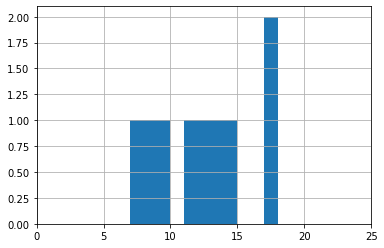

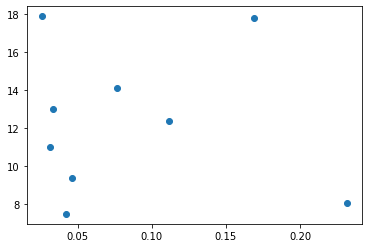

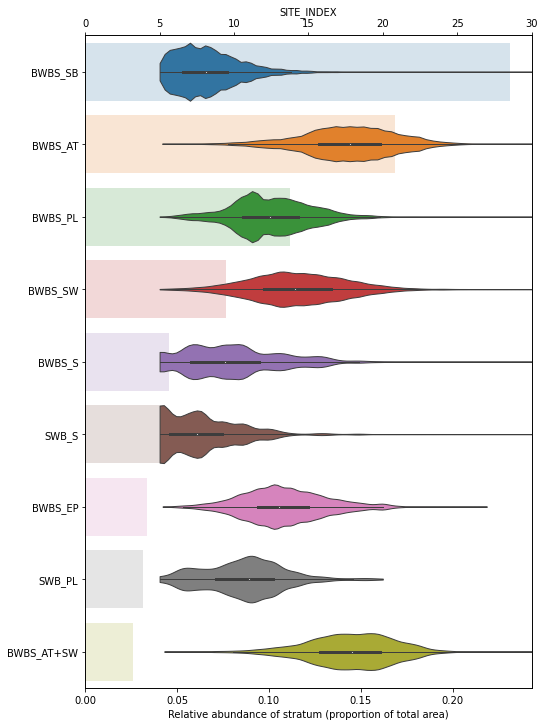

compiling stratum BWBS_SB
compiling stratum BWBS_AT
compiling stratum BWBS_PL
compiling stratum BWBS_SW
compiling stratum BWBS_S
compiling stratum SWB_S
compiling stratum BWBS_EP
compiling stratum SWB_PL
compiling stratum BWBS_AT+SW
BWBS_SB
   L max_vol too low 65.74495311008508 <function <lambda> at 0x7fc5a3d27ca0>
   M max_vol too low 124.31458158249247 <function <lambda> at 0x7fc5a3d27ca0>
   H bad leading species SB
BWBS_AT
   L SI too low (using 0.50 quantile) 14.9 17.0 15.0
   M bad leading species AT
   H bad leading species AT
BWBS_PL
   L SI too low (using 0.50 quantile) 10.4 18.0 15.0
   M SI too low (using 0.50 quantile) 12.5 18.6 15.0
   H 3002
    median SI (VRI)                15.1
    median SI (siteprod)           19.0
    median SI ratio (VRI/siteprod)  0.80
    species PL   84
    species PLI  16

BWBS_SW
   L 1003
    median SI (VRI)                11.8
    median SI (siteprod)           20.1
    median SI ratio (VRI/siteprod)  0.59
    species SW   85
    species SB


   M 2003
    median SI (VRI)                14.5
    median SI (siteprod)           19.4
    median SI ratio (VRI/siteprod)  0.75
    species SW   88
    species AT   12

   H 3003
    median SI (VRI)                17.3
    median SI (siteprod)           19.6
    median SI ratio (VRI/siteprod)  0.88
    species SW   86
    species AT   14

BWBS_S
   L max_vol too low 102.26900155933805 <function <lambda> at 0x7fc5a3d27ca0>
   M SI too low (using 0.50 quantile) 9.4 22.7 10.0
   H 3004
    median SI (VRI)                12.8
    median SI (siteprod)           21.7
    median SI ratio (VRI/siteprod)  0.59
    species S   100



SWB_S
   L max_vol too low 68.59825485027213 <function <lambda> at 0x7fc5a3d27ca0>
   M max_vol too low 115.31562312672841 <function <lambda> at 0x7fc5a3d27ca0>
   H 3005
    median SI (VRI)                10.7
    median SI (siteprod)           17.9
    median SI ratio (VRI/siteprod)  0.60
    species S    83
    species PL   17

BWBS_EP
   L bad leading species EP
   M bad leading species EP
   H bad leading species EP
SWB_PL
   L max_vol too low 105.3269908274206 <function <lambda> at 0x7fc5a3d27ca0>
   M SI too low (using 0.50 quantile) 10.5 17.3 15.0
   H SI too low (using 0.50 quantile) 12.6 17.2 15.0
BWBS_AT+SW
   L SI too low (using 0.50 quantile) 13.9 16.8 15.0
   M bad leading species AT
   H bad leading species AT


processing tsa 16
mean stratum SI IQR 2.850087080683027
coverage 0.7551872911795563
count 12


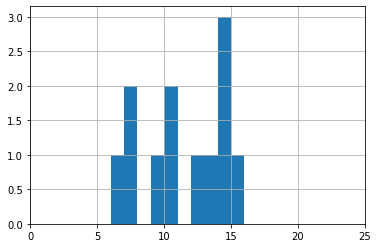

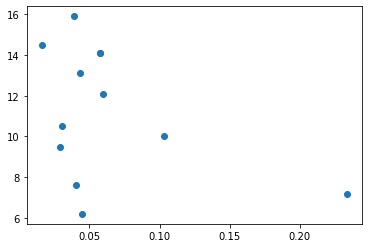

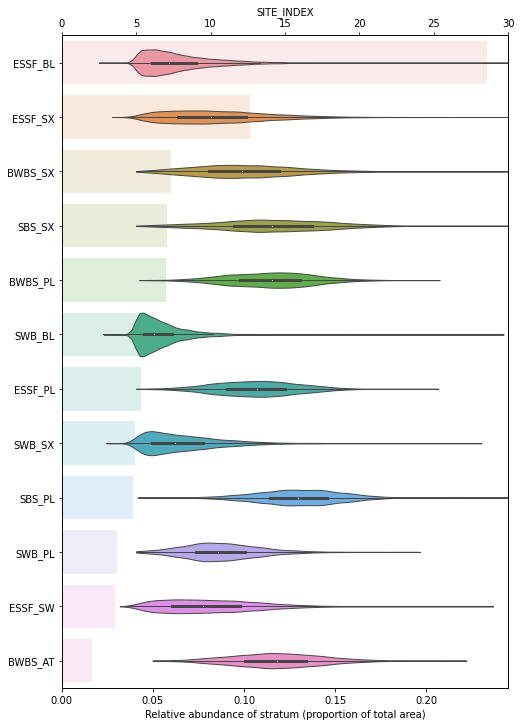

compiling stratum ESSF_BL
compiling stratum ESSF_SX
compiling stratum BWBS_SX
compiling stratum SBS_SX
compiling stratum BWBS_PL
compiling stratum SWB_BL
compiling stratum ESSF_PL
compiling stratum SWB_SX
compiling stratum SBS_PL
compiling stratum SWB_PL
compiling stratum ESSF_SW
compiling stratum BWBS_AT
ESSF_BL
   L max_vol too low 86.71318501295833 <function <lambda> at 0x7fc5a31a1b80>
   M max_vol too low 140.4910156307631 <function <lambda> at 0x7fc5a31a1b80>
   H 3000
    median SI (VRI)                 9.6
    median SI (siteprod)           13.5
    median SI ratio (VRI/siteprod)  0.71
    species BL   77
    species SX   23

ESSF_SX
   L max_vol too low 138.80438296490655 <function <lambda> at 0x7fc5a31a1b80>
   M 2001
    median SI (VRI)                10.0
    median SI (siteprod)           15.1
    median SI ratio (VRI/siteprod)  0.66
    species SX   75
    species BL   25



   H 3001
    median SI (VRI)                13.1
    median SI (siteprod)           18.1
    median SI ratio (VRI/siteprod)  0.72
    species SX   69
    species BL   18
    species PL   13

BWBS_SX
   L max_vol too low 119.84119676749499 <function <lambda> at 0x7fc5a31a1b80>
   M 2002
    median SI (VRI)                11.7
    median SI (siteprod)           10.0
    median SI ratio (VRI/siteprod)  1.17
    species SX   83
    species PL   17



   H 3002
    median SI (VRI)                15.1
    median SI (siteprod)           19.3
    median SI ratio (VRI/siteprod)  0.78
    species SX   71
    species PL   16
    species SW   13



SBS_SX
   L 1003
    median SI (VRI)                10.8
    median SI (siteprod)           18.6
    median SI ratio (VRI/siteprod)  0.58
    species SX   70
    species BL   16
    species SW   14

   M 2003
    median SI (VRI)                14.6
    median SI (siteprod)           18.8
    median SI ratio (VRI/siteprod)  0.78
    species SX   70
    species AT   15
    species SW   15



   H 3003
    median SI (VRI)                18.1
    median SI (siteprod)           18.9
    median SI ratio (VRI/siteprod)  0.96
    species SX   57
    species AT   29
    species PL   14

BWBS_PL
   L max_vol too low 149.9192191345332 <function <lambda> at 0x7fc5a31a1b80>
   M 2004
    median SI (VRI)                13.9
    median SI (siteprod)           17.3
    median SI ratio (VRI/siteprod)  0.80
    species PL   84
    species SX   16



   H 3004
    median SI (VRI)                16.4
    median SI (siteprod)           17.5
    median SI ratio (VRI/siteprod)  0.94
    species PL   82
    species SX   18

SWB_BL
   L max_vol too low 59.51463803615588 <function <lambda> at 0x7fc5a31a1b80>
   M max_vol too low 82.64584851485088 <function <lambda> at 0x7fc5a31a1b80>
   H max_vol too low 132.0313572588192 <function <lambda> at 0x7fc5a31a1b80>
ESSF_PL
   L max_vol too low 102.72467039558668 <function <lambda> at 0x7fc5a31a1b80>
   M max_vol too low 149.45350959755294 <function <lambda> at 0x7fc5a31a1b80>


   H 3006
    median SI (VRI)                15.4
    median SI (siteprod)           16.2
    median SI ratio (VRI/siteprod)  0.95
    species PL   81
    species SX   19

SWB_SX
   L max_vol too low 76.02250444875175 <function <lambda> at 0x7fc5a31a1b80>
   M max_vol too low 113.46380790600026 <function <lambda> at 0x7fc5a31a1b80>
   H 3007
    median SI (VRI)                10.0
    median SI (siteprod)            9.1
    median SI ratio (VRI/siteprod)  1.10
    species SX   72
    species PL   16
    species BL   12



SBS_PL
   L 1008
    median SI (VRI)                12.7
    median SI (siteprod)           18.8
    median SI ratio (VRI/siteprod)  0.67
    species PL   50
    species BL   28
    species SX   22

   M 2008
    median SI (VRI)                15.6
    median SI (siteprod)           19.2
    median SI ratio (VRI/siteprod)  0.81
    species PL   80
    species SX   20



   H 3008
    median SI (VRI)                18.2
    median SI (siteprod)           19.5
    median SI ratio (VRI/siteprod)  0.93
    species PL   80
    species SX   20

SWB_PL
   L max_vol too low 90.22867838511647 <function <lambda> at 0x7fc5a31a1b80>
   M max_vol too low 136.25450114129077 <function <lambda> at 0x7fc5a31a1b80>
   H 3009
    median SI (VRI)                12.8
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.85
    species PL   82
    species SX   18



ESSF_SW
   L 1010
    median SI (VRI)                 7.0
    median SI (siteprod)           18.3
    median SI ratio (VRI/siteprod)  0.38
    species SW   74
    species BL   26

   M 2010
    median SI (VRI)                 9.5
    median SI (siteprod)           18.6
    median SI ratio (VRI/siteprod)  0.51
    species SW   77
    species BL   23



   H 3010
    median SI (VRI)                12.8
    median SI (siteprod)           18.7
    median SI ratio (VRI/siteprod)  0.68
    species SW   71
    species BL   15
    species PL   13

BWBS_AT
   L max_vol too low 144.8389732449009 <function <lambda> at 0x7fc5a31a1b80>
   M 2011
    median SI (VRI)                14.7
    median SI (siteprod)           15.5
    median SI ratio (VRI/siteprod)  0.95
    species AT   65
    species SX   18
    species PL   17



   H 3011
    median SI (VRI)                17.3
    median SI (siteprod)           15.9
    median SI ratio (VRI/siteprod)  1.09
    species AT   58
    species SX   18
    species AC   13
    species PL   12



processing tsa 24
mean stratum SI IQR 2.5866000022888183
coverage 0.7796793242997877
count 8


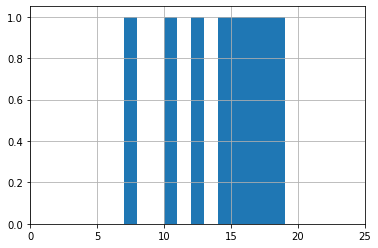

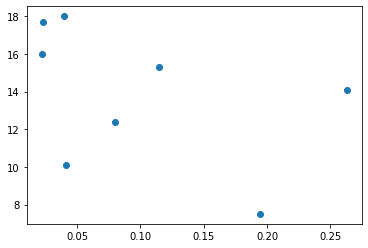

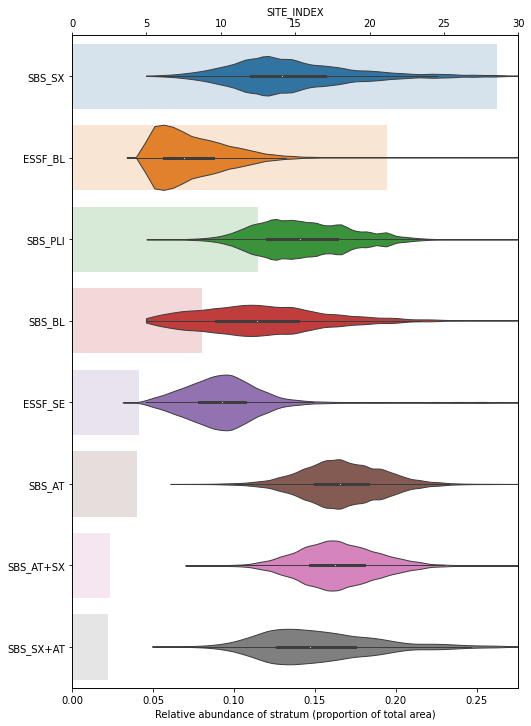

compiling stratum SBS_SX
compiling stratum ESSF_BL
compiling stratum SBS_PLI
compiling stratum SBS_BL
compiling stratum ESSF_SE
compiling stratum SBS_AT
compiling stratum SBS_AT+SX
compiling stratum SBS_SX+AT
SBS_SX
   L max_vol too low 151.200087053032 <function <lambda> at 0x7fc6b3dd9c10>
   M 2000
    median SI (VRI)                13.6
    median SI (siteprod)           19.1
    median SI ratio (VRI/siteprod)  0.71
    species SX   82
    species BL   18



   H 3000
    median SI (VRI)                17.5
    median SI (siteprod)           19.6
    median SI ratio (VRI/siteprod)  0.90
    species SX   84
    species BL   16

ESSF_BL
   L max_vol too low 99.04265887929283 <function <lambda> at 0x7fc6b3dd9c10>
   M max_vol too low 151.63808623065268 <function <lambda> at 0x7fc6b3dd9c10>
   H 3001
    median SI (VRI)                10.5
    median SI (siteprod)           14.9
    median SI ratio (VRI/siteprod)  0.70
    species BL   82
    species SE   18



SBS_PLI
   L 1002
    median SI (VRI)                12.9
    median SI (siteprod)           18.6
    median SI ratio (VRI/siteprod)  0.69
    species PLI  83
    species SX   17

   M 2002
    median SI (VRI)                15.7
    median SI (siteprod)           20.2
    median SI ratio (VRI/siteprod)  0.78
    species PLI  64
    species FDI  19
    species SX   18



   H 3002
    median SI (VRI)                18.7
    median SI (siteprod)           20.5
    median SI ratio (VRI/siteprod)  0.91
    species PLI  46
    species FDI  35
    species SX   19

SBS_BL
   L max_vol too low 167.09054165539445 <function <lambda> at 0x7fc6b3dd9c10>
   M 2003
    median SI (VRI)                12.4
    median SI (siteprod)           17.0
    median SI ratio (VRI/siteprod)  0.73
    species BL   74
    species SX   26



   H 3003
    median SI (VRI)                16.2
    median SI (siteprod)           18.7
    median SI ratio (VRI/siteprod)  0.87
    species BL   69
    species SX   31

ESSF_SE
   L max_vol too low 160.44088144948995 <function <lambda> at 0x7fc6b3dd9c10>
   M 2004
    median SI (VRI)                10.5
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.70
    species SE   59
    species BL   29
    species SX   12



   H 3004
    median SI (VRI)                12.9
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.86
    species SE   34
    species SX   26
    species BL   23
    species SW   17

SBS_AT
   L bad leading species AT
   M bad leading species AT
   H bad leading species AT
SBS_AT+SX
   L bad leading species AT
   

M bad leading species AT
   H bad leading species AT
SBS_SX+AT
   L 1007
    median SI (VRI)                13.7
    median SI (siteprod)           19.3
    median SI ratio (VRI/siteprod)  0.71
    species SX   73
    species AT   27

   M 2007
    median SI (VRI)                16.8
    median SI (siteprod)           19.6
    median SI ratio (VRI/siteprod)  0.86
    species SX   73
    species AT   27



   H 3007
    median SI (VRI)                20.7
    median SI (siteprod)           20.0
    median SI ratio (VRI/siteprod)  1.04
    species SX   72
    species AT   28



processing tsa 40
mean stratum SI IQR 2.303548397556428
coverage 0.7706647557868248
count 7


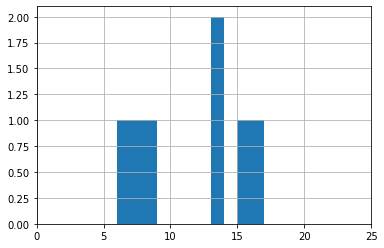

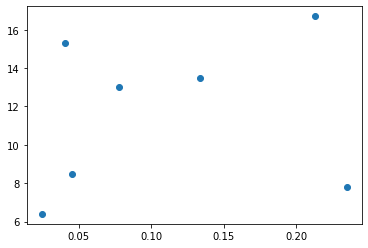

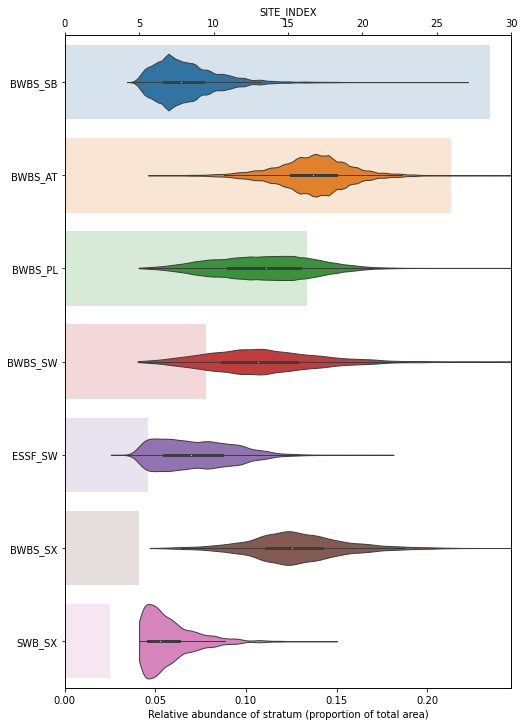

compiling stratum BWBS_SB
compiling stratum BWBS_AT
compiling stratum BWBS_PL
compiling stratum BWBS_SW
compiling stratum ESSF_SW
compiling stratum BWBS_SX
compiling stratum SWB_SX
BWBS_SB
   L max_vol too low 68.32240212770444 <function <lambda> at 0x7fc74beb8b80>
   M max_vol too low 110.59716829679074 <function <lambda> at 0x7fc74beb8b80>
   H bad leading species SB
BWBS_AT
   L 1001
    median SI (VRI)                14.2
    median SI (siteprod)           17.2
    median SI ratio (VRI/siteprod)  0.82
    species AT  100



   M 2001
    median SI (VRI)                16.7
    median SI (siteprod)           17.6
    median SI ratio (VRI/siteprod)  0.95
    species AT  100

   H 3001
    median SI (VRI)                18.6
    median SI (siteprod)           17.7
    median SI ratio (VRI/siteprod)  1.05
    species AT  100



BWBS_PL
   L 1002
    median SI (VRI)                10.2
    median SI (siteprod)           19.1
    median SI ratio (VRI/siteprod)  0.53
    species PL   86
    species SB   14

   M 2002
    median SI (VRI)                13.6
    median SI (siteprod)           19.2
    median SI ratio (VRI/siteprod)  0.71
    species PL  100



   H 3002
    median SI (VRI)                16.3
    median SI (siteprod)           19.3
    median SI ratio (VRI/siteprod)  0.85
    species PL  100

BWBS_SW
   L 1003
    median SI (VRI)                10.4
    median SI (siteprod)           18.8
    median SI ratio (VRI/siteprod)  0.55
    species SW  100



   M 2003
    median SI (VRI)                13.2
    median SI (siteprod)           18.9
    median SI ratio (VRI/siteprod)  0.70
    species SW  100

   H 3003
    median SI (VRI)                16.7
    median SI (siteprod)           20.0
    median SI ratio (VRI/siteprod)  0.83
    species SW  100



ESSF_SW
   L max_vol too low 104.39399110239924 <function <lambda> at 0x7fc74beb8b80>
   M 2004
    median SI (VRI)                 8.9
    median SI (siteprod)           16.4
    median SI ratio (VRI/siteprod)  0.54
    species SW   86
    species PL   14

   H 3004
    median SI (VRI)                11.6
    median SI (siteprod)           16.7
    median SI ratio (VRI/siteprod)  0.70
    species SW   77
    species PL   23



BWBS_SX
   L 1005
    median SI (VRI)                13.3
    median SI (siteprod)            nan
    median SI ratio (VRI/siteprod)  nan
    species SX   87
    species AT   13



   M 2005
    median SI (VRI)                15.4
    median SI (siteprod)            nan
    median SI ratio (VRI/siteprod)  nan
    species SX   86
    species AT   14

   H 3005
    median SI (VRI)                18.0
    median SI (siteprod)            nan
    median SI ratio (VRI/siteprod)  nan
    species SX   86
    species AT   14



SWB_SX
   L max_vol too low 55.8306357073447 <function <lambda> at 0x7fc74beb8b80>
   M max_vol too low 93.38401505649642 <function <lambda> at 0x7fc74beb8b80>
   H 3006
    median SI (VRI)                 8.9
    median SI (siteprod)            8.7
    median SI ratio (VRI/siteprod)  1.02
    species SW   45
    species SX   42
    species PL   14



processing tsa 41
mean stratum SI IQR 2.6742248096207315
coverage 0.7493437963888625
count 10


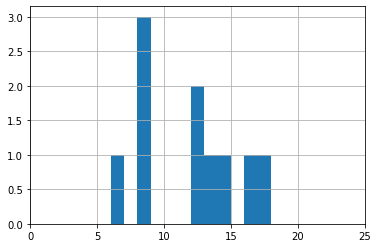

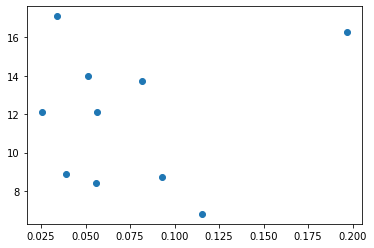

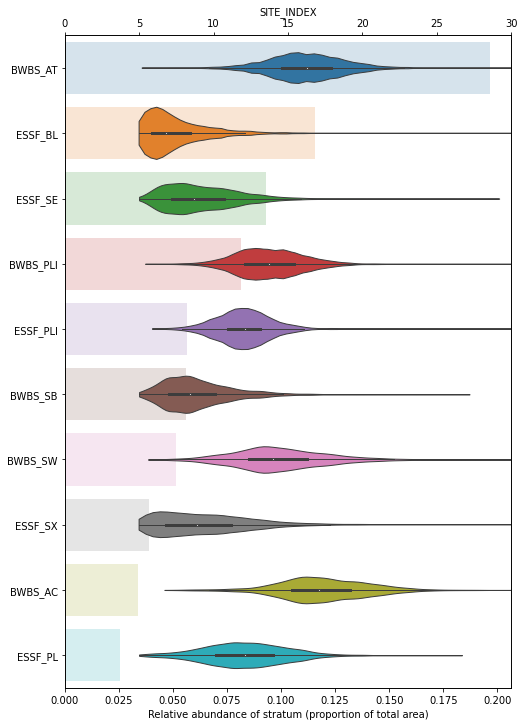

compiling stratum BWBS_AT
compiling stratum ESSF_BL
compiling stratum ESSF_SE
compiling stratum BWBS_PLI
compiling stratum ESSF_PLI
compiling stratum BWBS_SB
compiling stratum BWBS_SW
compiling stratum ESSF_SX
compiling stratum BWBS_AC
compiling stratum ESSF_PL
BWBS_AT
   L 1000
    median SI (VRI)                13.7
    median SI (siteprod)           18.3
    median SI ratio (VRI/siteprod)  0.75
    species AT  100



   M 2000
    median SI (VRI)                15.7
    median SI (siteprod)           18.4
    median SI ratio (VRI/siteprod)  0.86
    species AT  100

   H 3000
    median SI (VRI)                18.0
    median SI (siteprod)           18.2
    median SI ratio (VRI/siteprod)  0.99
    species AT  100



ESSF_BL
   L max_vol too low 103.46151975318257 <function <lambda> at 0x7fc5abf41940>
   M bad leading species BL
   H bad leading species BL
ESSF_SE
   L 1002
    median SI (VRI)                 7.0
    median SI (siteprod)           17.6
    median SI ratio (VRI/siteprod)  0.40
    species SE   77
    species BL   23



   M 2002
    median SI (VRI)                 8.8
    median SI (siteprod)           17.6
    median SI ratio (VRI/siteprod)  0.50
    species SE   81
    species BL   19

   H 3002
    median SI (VRI)                11.4
    median SI (siteprod)           17.5
    median SI ratio (VRI/siteprod)  0.65
    species SE   73
    species PLI  15
    species BL   12

BWBS_PLI
   L 1003
    median SI (VRI)                12.0
    median SI (siteprod)           18.0
    median SI ratio (VRI/siteprod)  0.67
    species PL   53
    species PLI  47

   M 2003
    median SI (VRI)                14.0
    median SI (siteprod)           18.0
    median SI ratio (VRI/siteprod)  0.78
    species PL   55
    species PLI  45



   H 3003
    median SI (VRI)                16.3
    median SI (siteprod)           18.0
    median SI ratio (VRI/siteprod)  0.91
    species PL   59
    species PLI  41

ESSF_PLI
   L 1004
    median SI (VRI)                10.5
    median SI (siteprod)           19.1
    median SI ratio (VRI/siteprod)  0.55
    species PLI  84
    species SE   16



   M 2004
    median SI (VRI)                12.0
    median SI (siteprod)           19.2
    median SI ratio (VRI/siteprod)  0.62
    species PLI  87
    species SE   13

   H 3004
    median SI (VRI)                13.4
    median SI (siteprod)           19.3
    median SI ratio (VRI/siteprod)  0.69
    species PLI  88
    species SE   12



BWBS_SB
   L bad leading species SB
   M 2005
    median SI (VRI)                11.1
    median SI (siteprod)           15.8
    median SI ratio (VRI/siteprod)  0.70
    species SX   64
    species PL   20
    species SB   16

   H 3005
    median SI (VRI)                14.8
    median SI (siteprod)           21.0
    median SI ratio (VRI/siteprod)  0.70
    species SX   82
    species PL   18



BWBS_SW
   L 1006
    median SI (VRI)                11.8
    median SI (siteprod)           17.4
    median SI ratio (VRI/siteprod)  0.68
    species SW   85
    species PLI  15

   M 2006
    median SI (VRI)                14.0
    median SI (siteprod)           18.0
    median SI ratio (VRI/siteprod)  0.78
    species SW   87
    species PLI  13



   H 3006
    median SI (VRI)                17.0
    median SI (siteprod)           18.8
    median SI ratio (VRI/siteprod)  0.90
    species SW  100



ESSF_SX
   L 1007
    median SI (VRI)                 6.6
    median SI (siteprod)           21.7
    median SI ratio (VRI/siteprod)  0.30
    species SX   74
    species BL   26

   M 2007
    median SI (VRI)                 8.9
    median SI (siteprod)           21.5
    median SI ratio (VRI/siteprod)  0.41
    species SX   68
    species BL   18
    species PL   14



   H 3007
    median SI (VRI)                12.0
    median SI (siteprod)           21.5
    median SI ratio (VRI/siteprod)  0.56
    species SX   67
    species PL   21
    species BL   13

BWBS_AC
   L 1008
    median SI (VRI)                14.6
    median SI (siteprod)           18.3
    median SI ratio (VRI/siteprod)  0.80
    species AC   77
    species AT   23



   M 2008
    median SI (VRI)                17.0
    median SI (siteprod)           18.4
    median SI ratio (VRI/siteprod)  0.93
    species AC   69
    species AT   19
    species SW   12



   H 3008
    median SI (VRI)                19.9
    median SI (siteprod)           18.2
    median SI ratio (VRI/siteprod)  1.09
    species AC   85
    species AT   15

ESSF_PL
   L 1009
    median SI (VRI)                 9.7
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.65
    species PL   82
    species SX   18

   M 2009
    median SI (VRI)                12.0
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.80
    species PL   83
    species SX   17

   H 3009
    median SI (VRI)                14.3
    median SI (siteprod)           15.0
    median SI ratio (VRI/siteprod)  0.96
    species PL   83
    species SX   17


In [29]:
if 1:
    force_run_vdyp = 0
    for tsa in ria_tsas[:]:
        stratum_col = 'stratum'
        %run 01a_run-tsa.ipynb

In [30]:
if 0:
    pickle.dump(vdyp_out_cache, open('vdyp_out_cache.pkl', 'wb'))

Pause running notebook and head to a Windows machine to run `02_input-tsa*.dat` files through BatchTIPSY, then copy `04_output-tsa*.out` files to `./data/`.

We tried to get TIPSY to run on a linux VM under Wine, but there is no way to run the software other than clicking through the GUI (yuck). We still might be able to get TIPSY fully automated, but this would require some sort of robot mouse click automation that we have not had time to figure out yet.

Loop over TSAs and run notebook `01b_run-tsa`. This compiles output data from TIPSY, and plots results on top of smoothed VDYP output (for visual inspection of AU-wise unmanaged+managed curve pairs, to confirm that projected yields are reasonable before proceeding).

0 21003
21003 BWBS_SW L
1 22003
22003 BWBS_SW M


2 23002
23002 BWBS_PL H
3 23003
23003 BWBS_SW H


4 23004
23004 BWBS_S H
5 23005
23005 SWB_S H


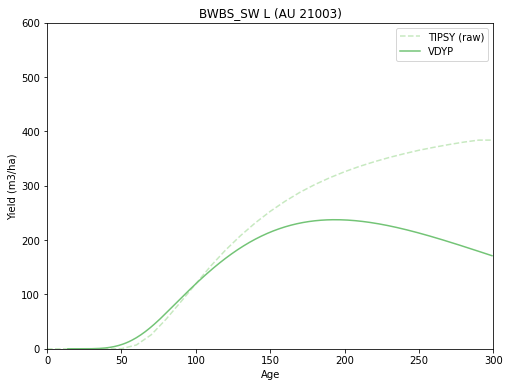

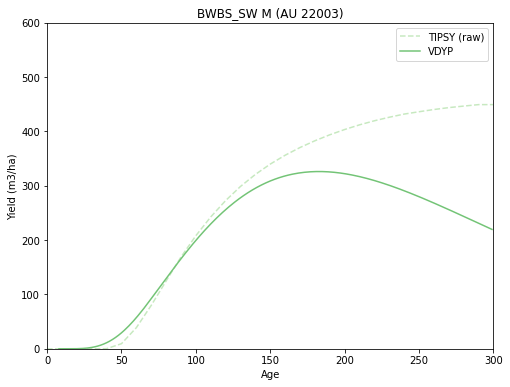

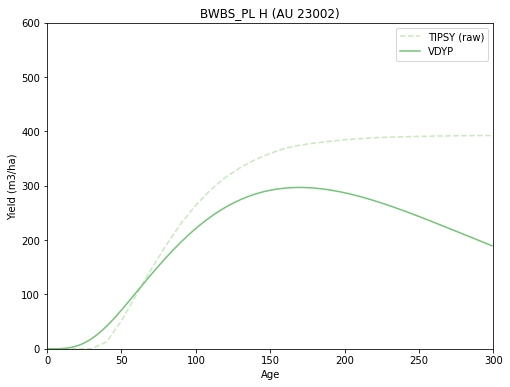

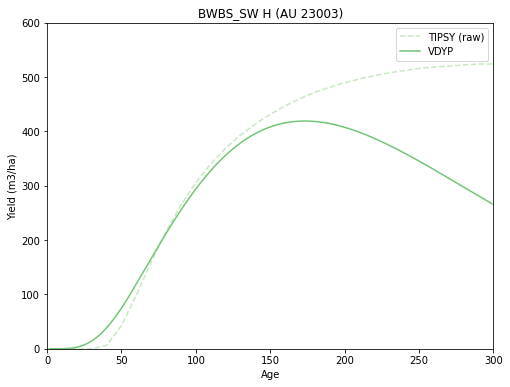

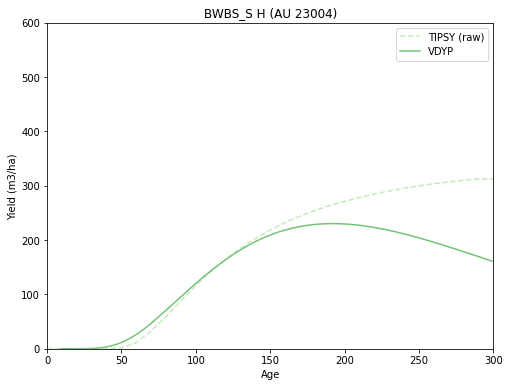

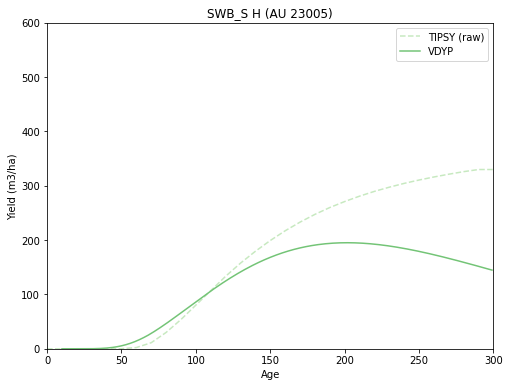

0 21003
21003 SBS_SX L
1 21008
21008 SBS_PL L


2 21010
21010 ESSF_SW L
3 22001
22001 ESSF_SX M


4 22002
22002 BWBS_SX M
5 22003
22003 SBS_SX M


6 22004
22004 BWBS_PL M
7 22008
22008 SBS_PL M


8 22010
22010 ESSF_SW M


9 22011
22011 BWBS_AT M
10 23000
23000 ESSF_BL H


11 23001
23001 ESSF_SX H
12 23002
23002 BWBS_SX H


13 23003
23003 SBS_SX H
14 23004
23004 BWBS_PL H


15 23006
23006 ESSF_PL H
16 23007
23007 SWB_SX H


17 23008
23008 SBS_PL H
18 23009
23009 SWB_PL H


19 23010
23010 ESSF_SW H
20 23011
23011 BWBS_AT H


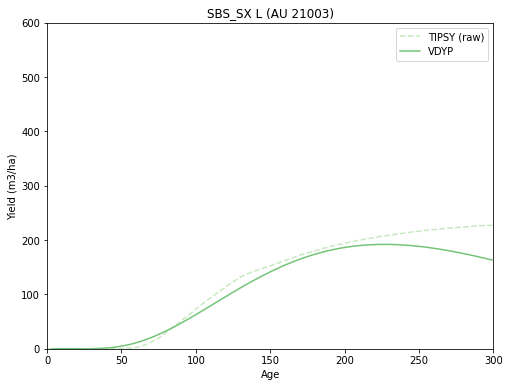

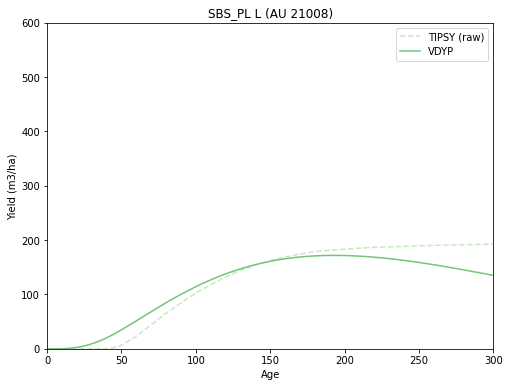

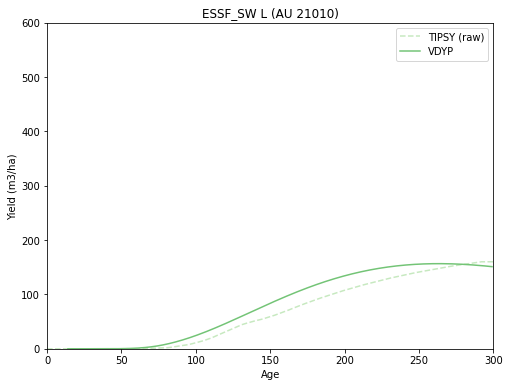

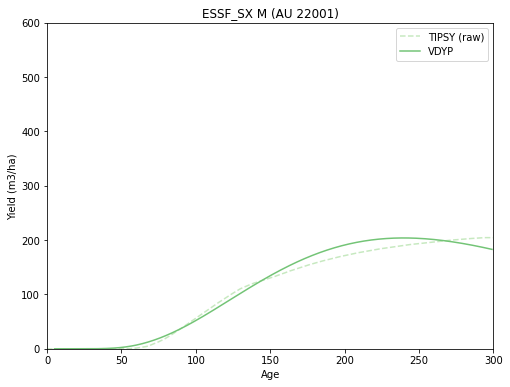

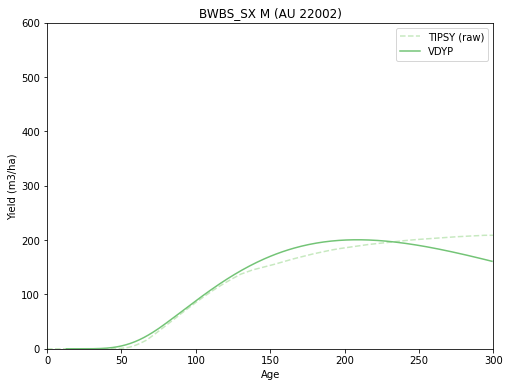

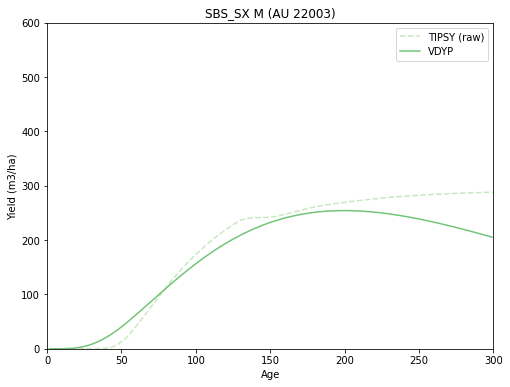

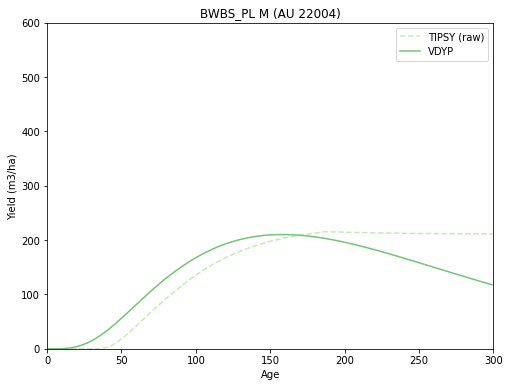

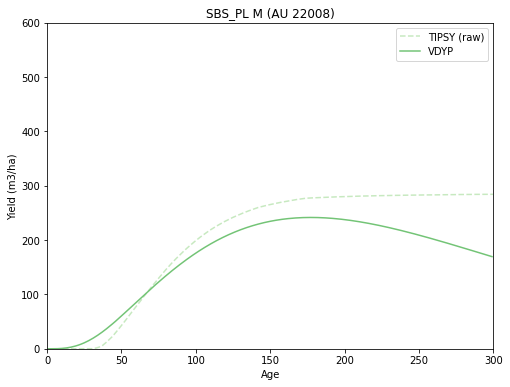

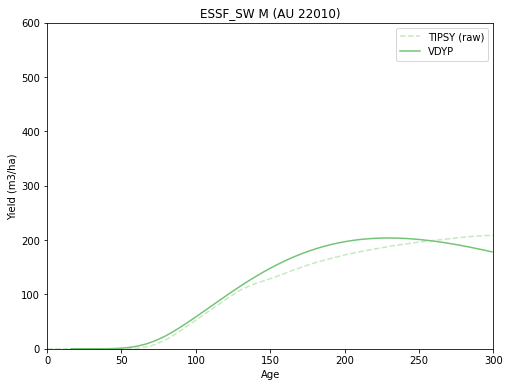

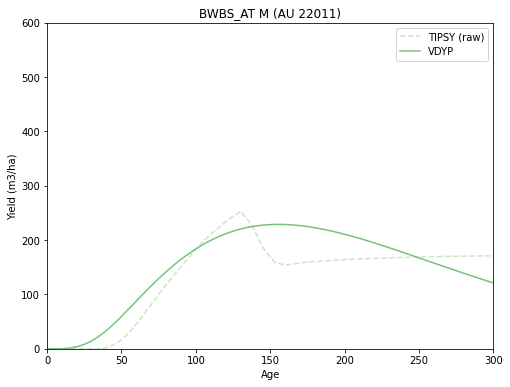

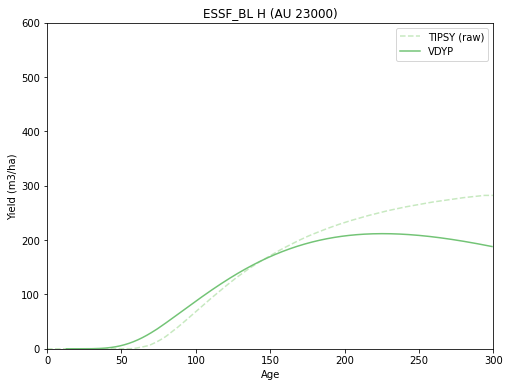

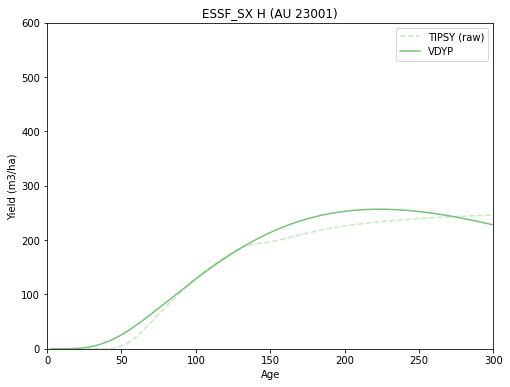

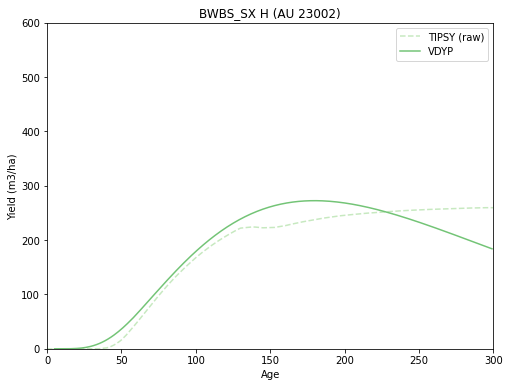

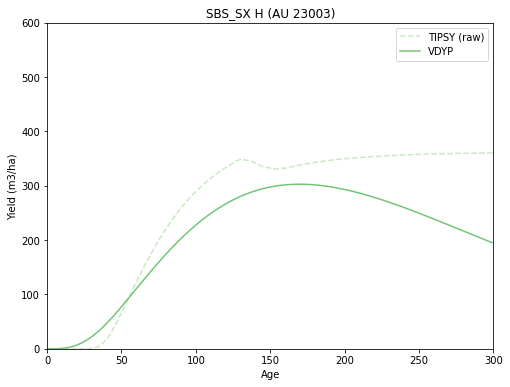

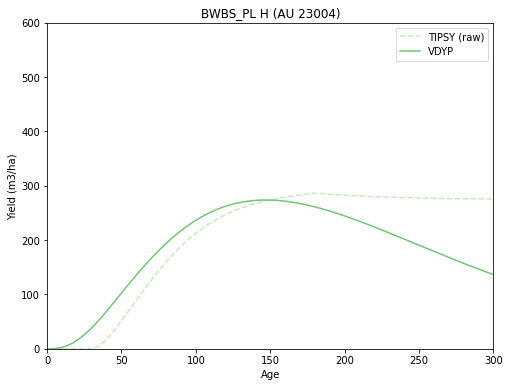

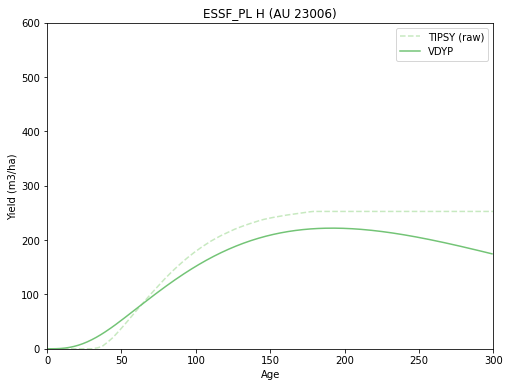

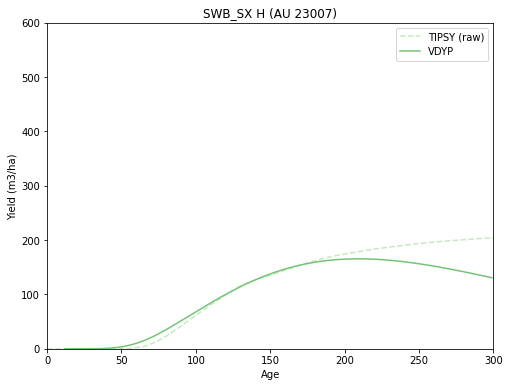

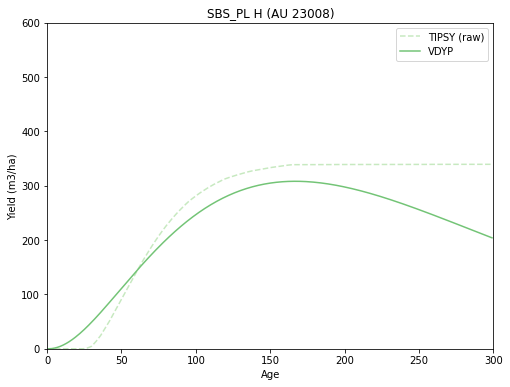

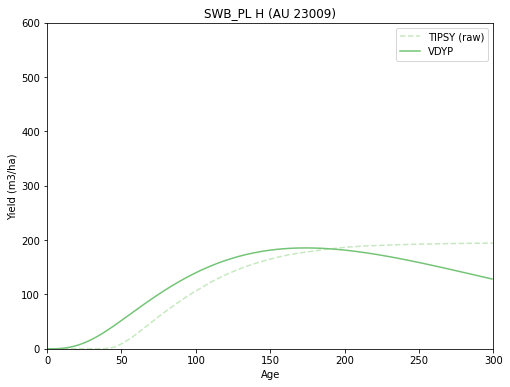

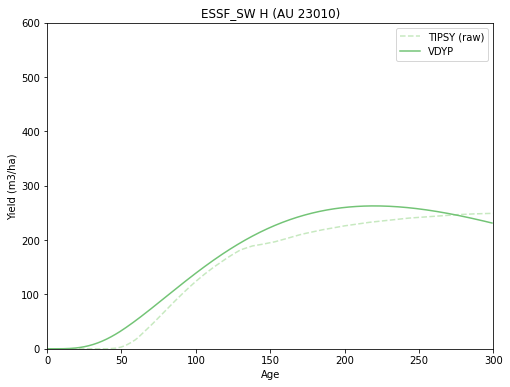

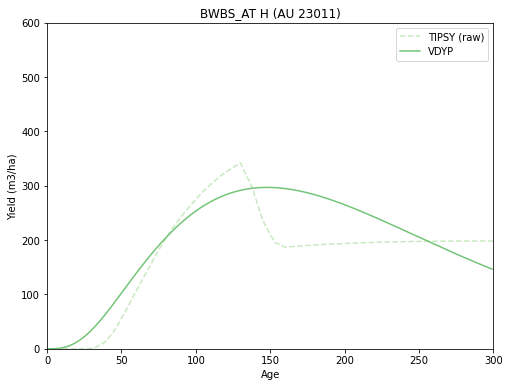

0 21002
21002 SBS_PLI L
1 21007
21007 SBS_SX+AT L


2 22000
22000 SBS_SX M
3 22002
22002 SBS_PLI M


4 22003
22003 SBS_BL M
5 22004
22004 ESSF_SE M


6 22007
22007 SBS_SX+AT M
7 23000
23000 SBS_SX H


8 23001
23001 ESSF_BL H
9 23002
23002 SBS_PLI H


10 23003
23003 SBS_BL H
11 23004
23004 ESSF_SE H


12 23007
23007 SBS_SX+AT H


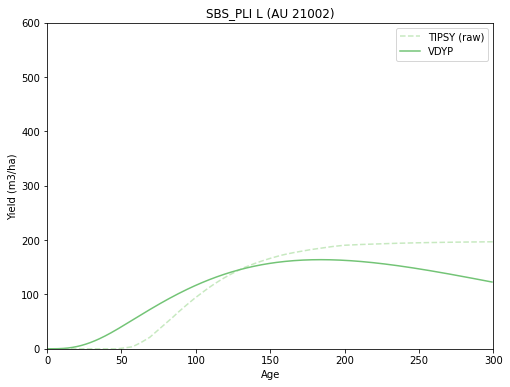

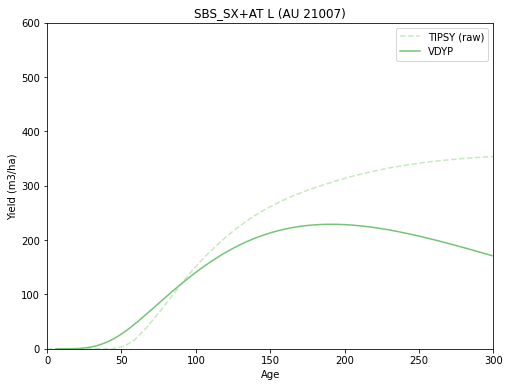

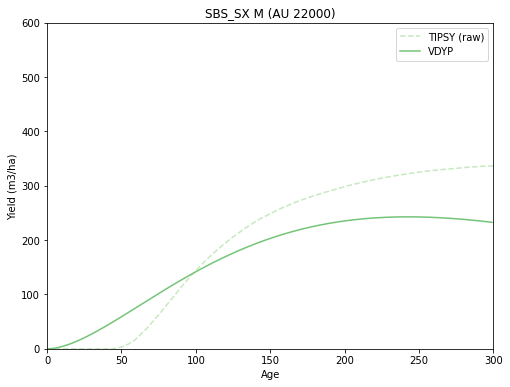

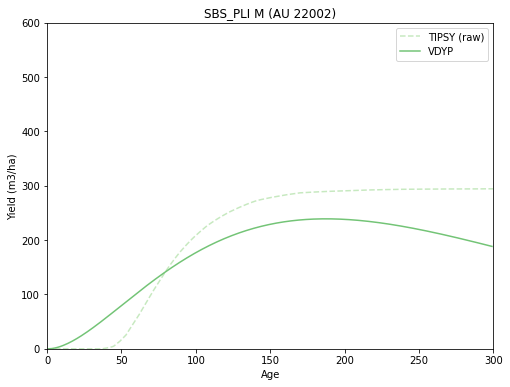

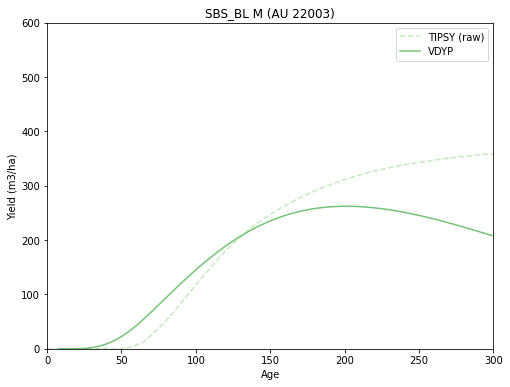

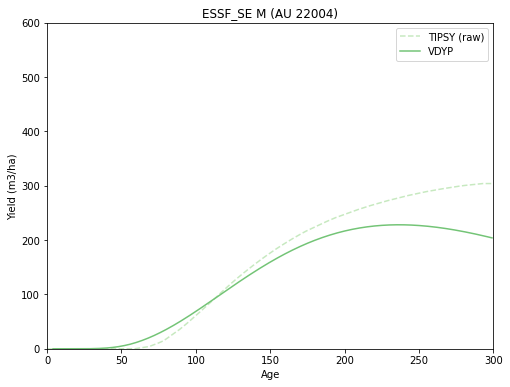

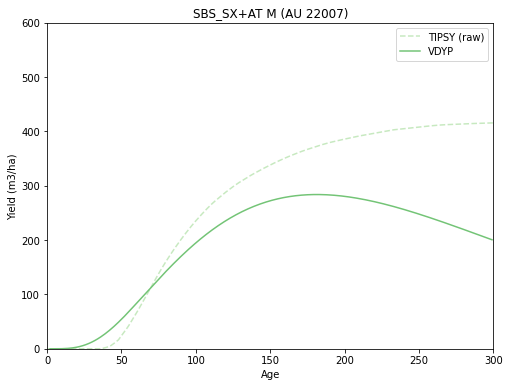

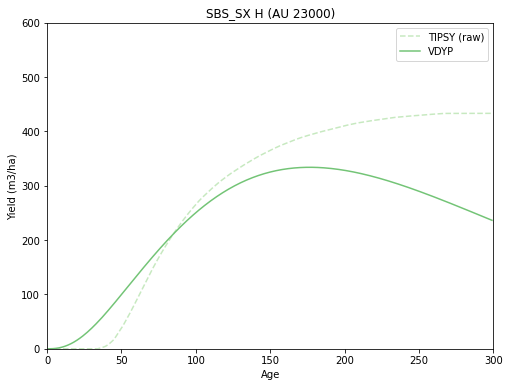

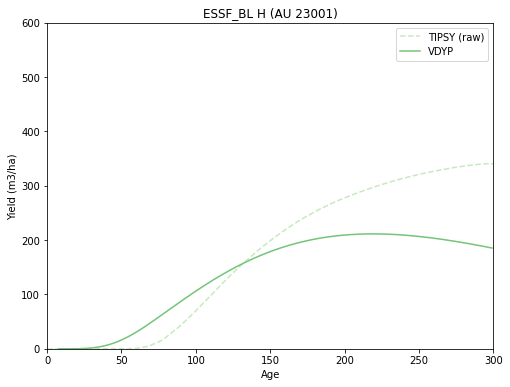

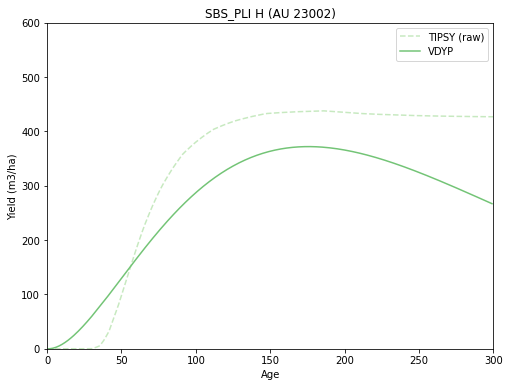

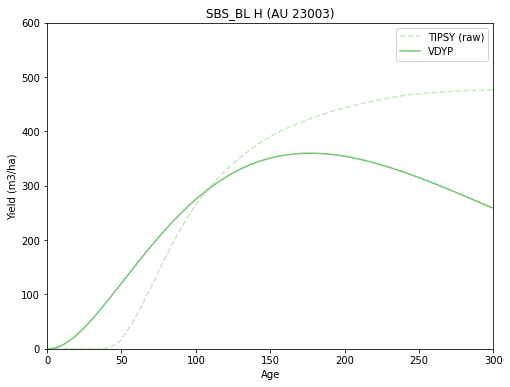

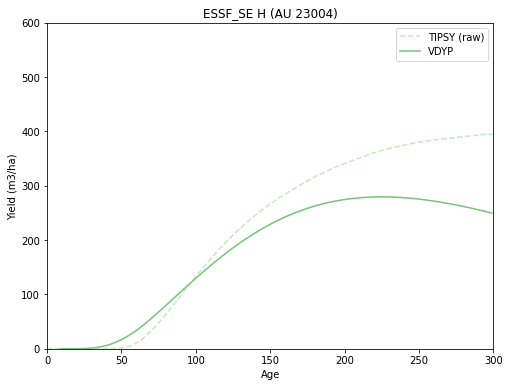

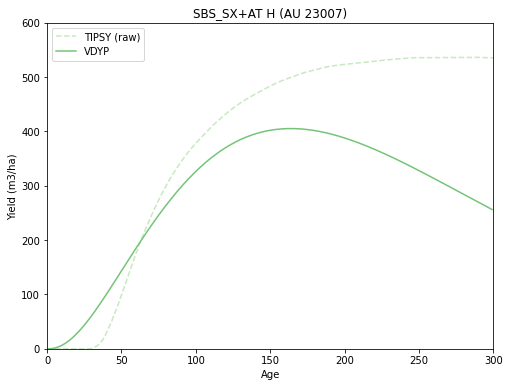

0 21001
21001 BWBS_AT L
1 21002
21002 BWBS_PL L


2 21003
21003 BWBS_SW L
3 21005
21005 BWBS_SX L


4 22001
22001 BWBS_AT M
5 22002
22002 BWBS_PL M


6 22003
22003 BWBS_SW M
7 22004
22004 ESSF_SW M


8 22005
22005 BWBS_SX M
9 23001
23001 BWBS_AT H


10 23002
23002 BWBS_PL H
11 23003
23003 BWBS_SW H


12 23004
23004 ESSF_SW H
13 23005
23005 BWBS_SX H


14 23006
23006 SWB_SX H


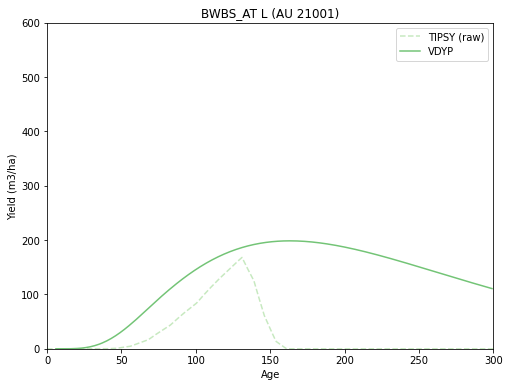

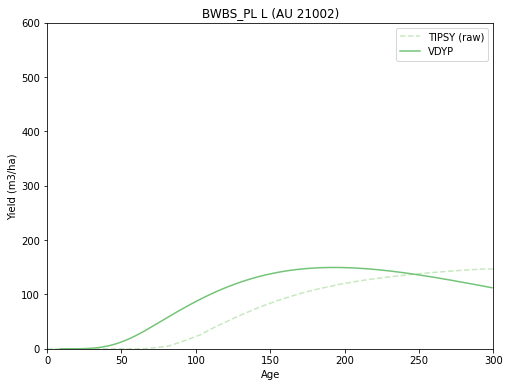

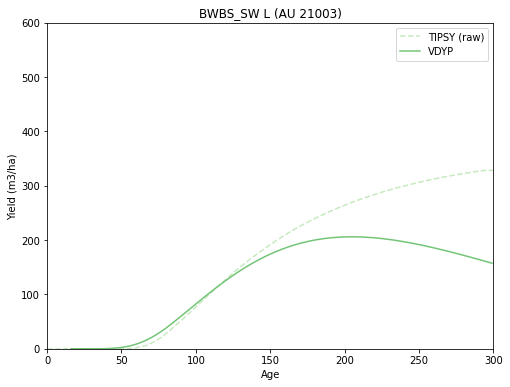

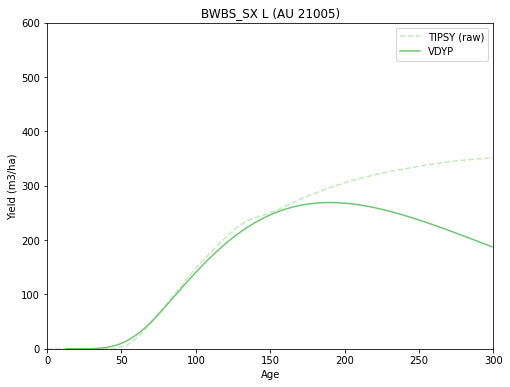

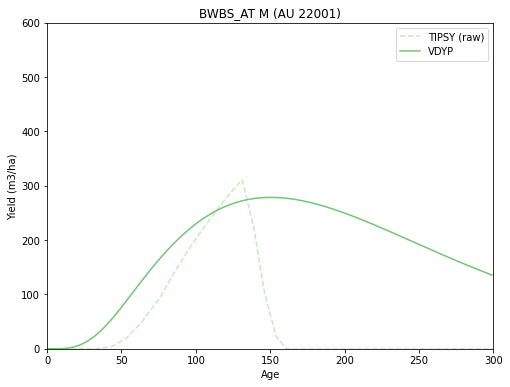

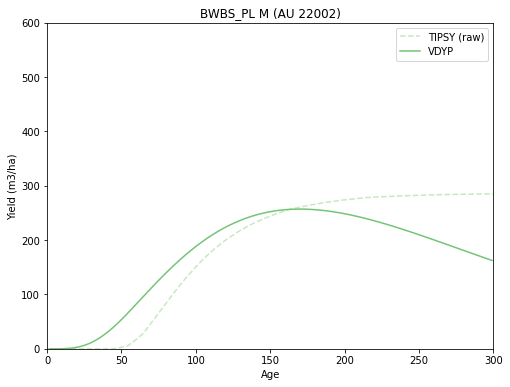

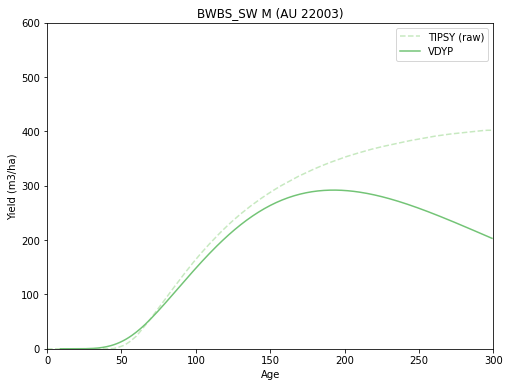

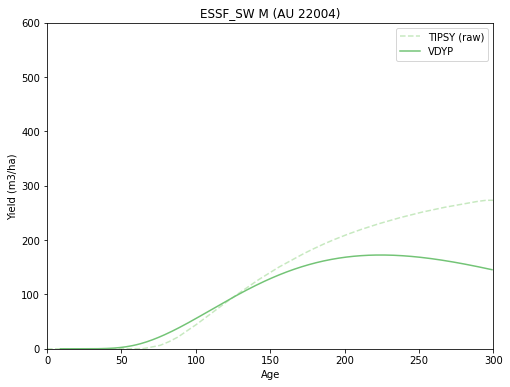

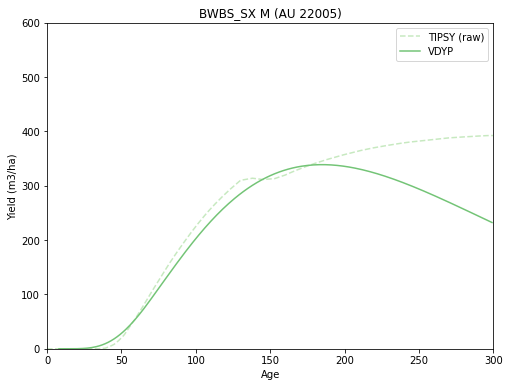

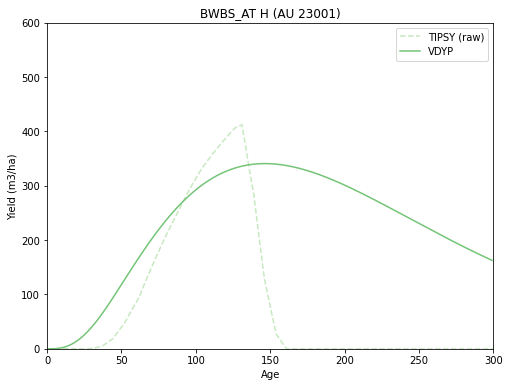

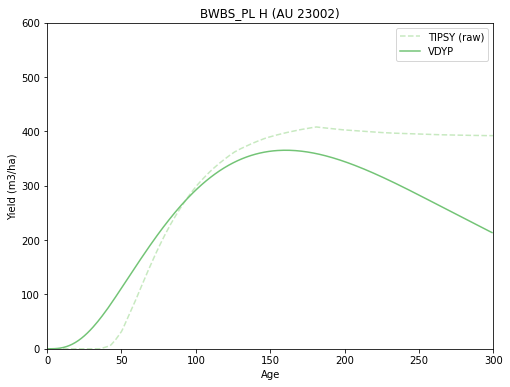

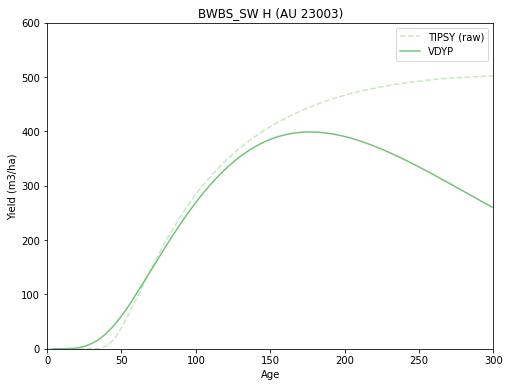

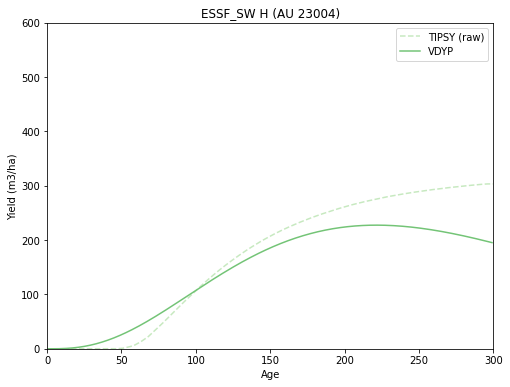

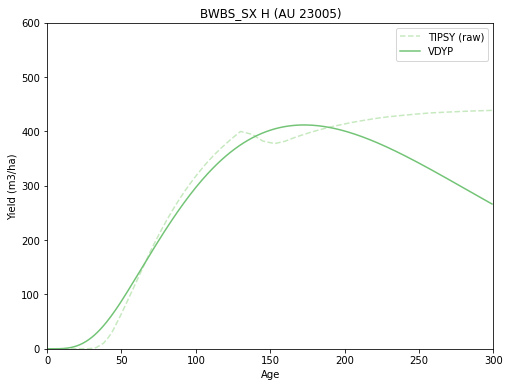

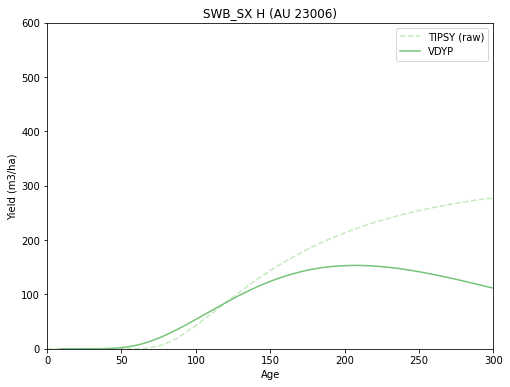

0 21000
21000 BWBS_AT L
1 21002
21002 ESSF_SE L


2 21003
21003 BWBS_PLI L
3 21004
21004 ESSF_PLI L


4 21006
21006 BWBS_SW L
5 21007
21007 ESSF_SX L


6 21008
21008 BWBS_AC L
7 21009
21009 ESSF_PL L


8 22000
22000 BWBS_AT M
9 22003
22003 BWBS_PLI M


10 22004
22004 ESSF_PLI M
11 22005
22005 BWBS_SB M


12 22006
22006 BWBS_SW M
13 22007
22007 ESSF_SX M


14 22008
22008 BWBS_AC M
15 22009
22009 ESSF_PL M


16 23000
23000 BWBS_AT H
17 23002
23002 ESSF_SE H


18 23003
23003 BWBS_PLI H
19 23004
23004 ESSF_PLI H


20 23005
23005 BWBS_SB H
21 23006
23006 BWBS_SW H


22 23007
23007 ESSF_SX H
23 23008
23008 BWBS_AC H


24 23009
23009 ESSF_PL H


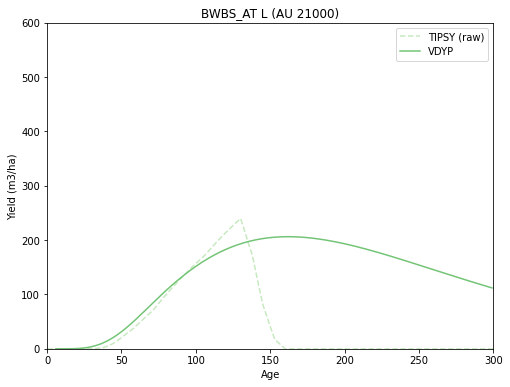

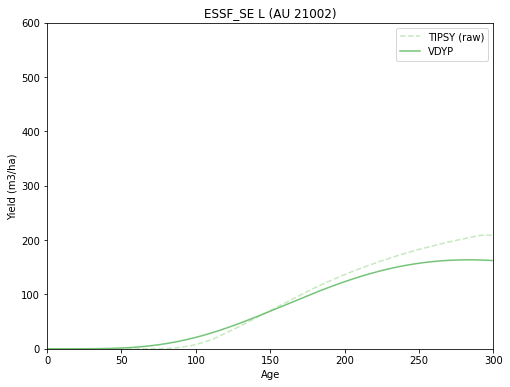

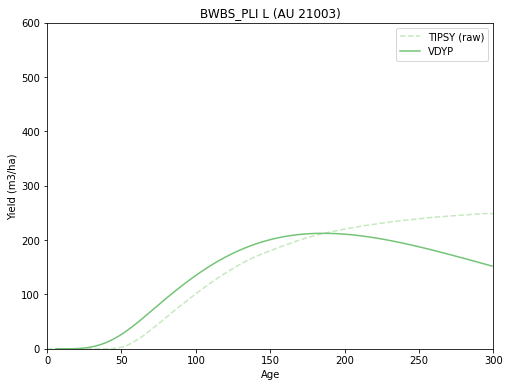

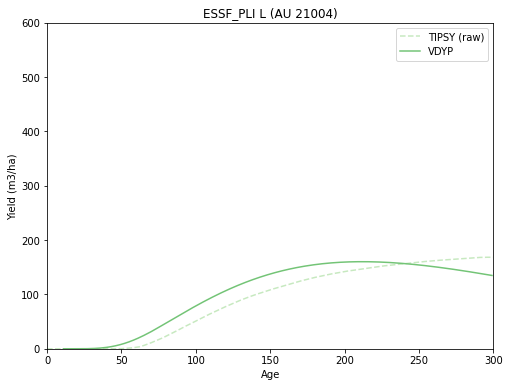

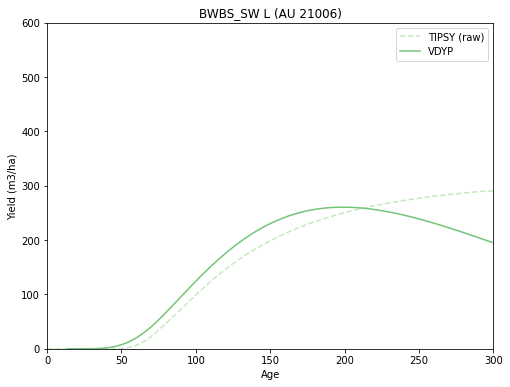

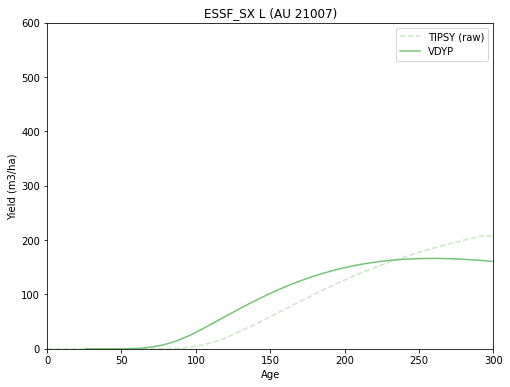

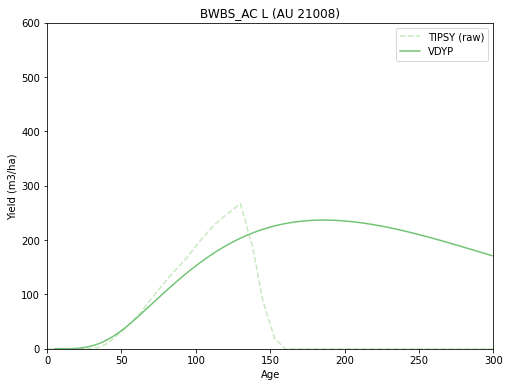

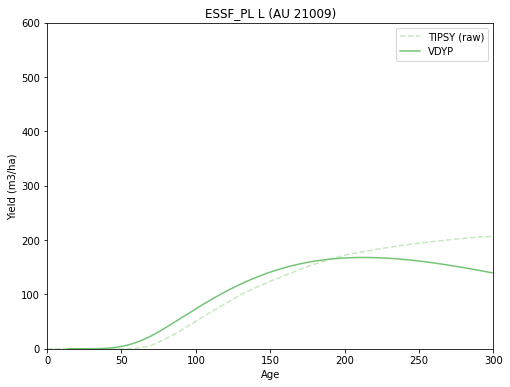

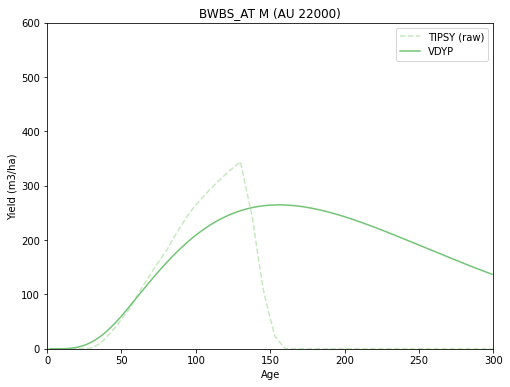

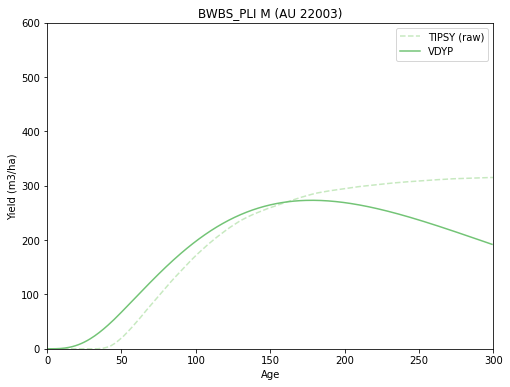

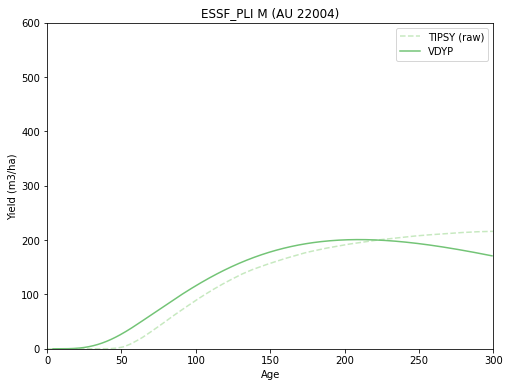

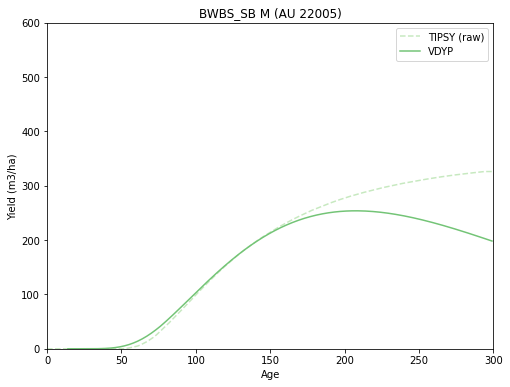

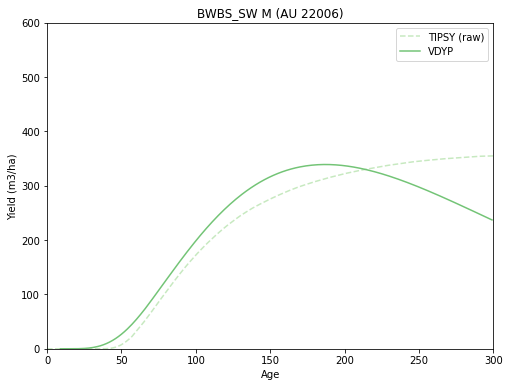

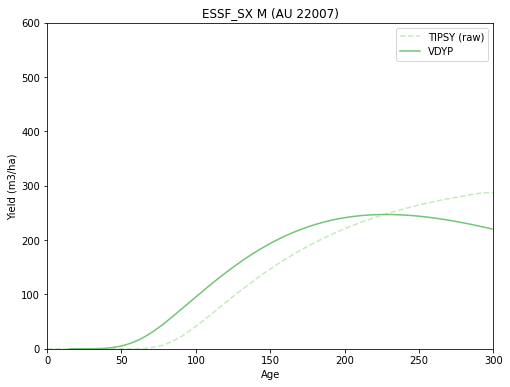

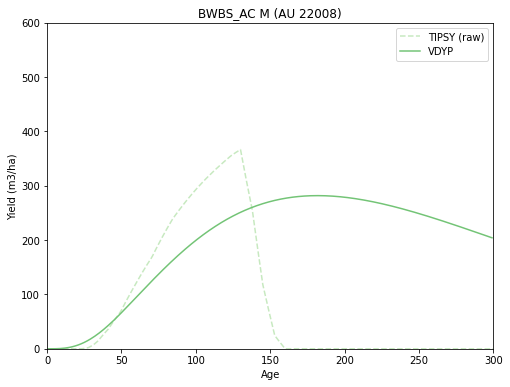

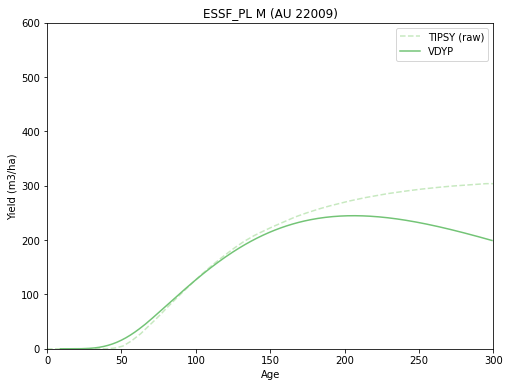

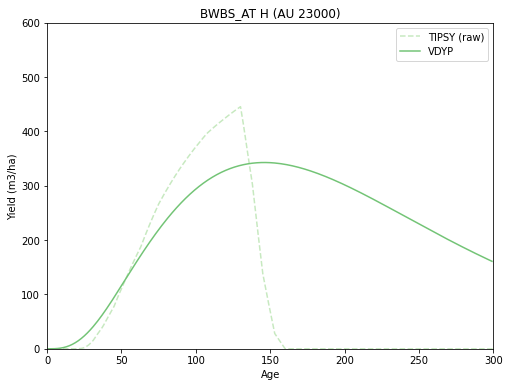

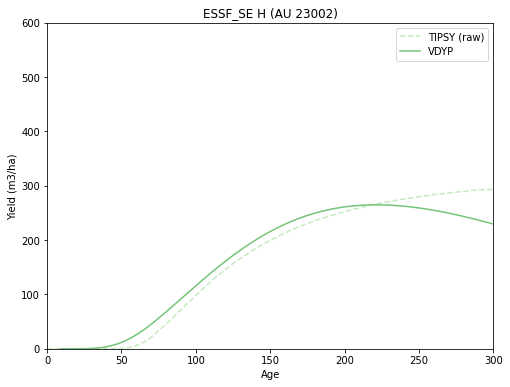

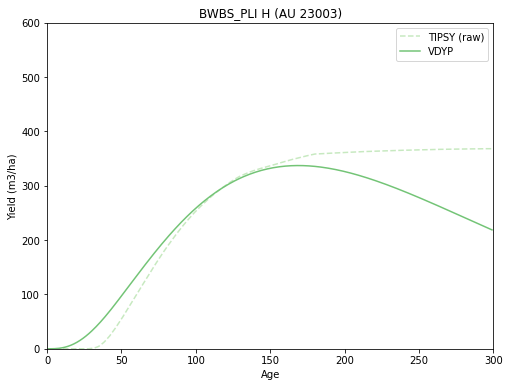

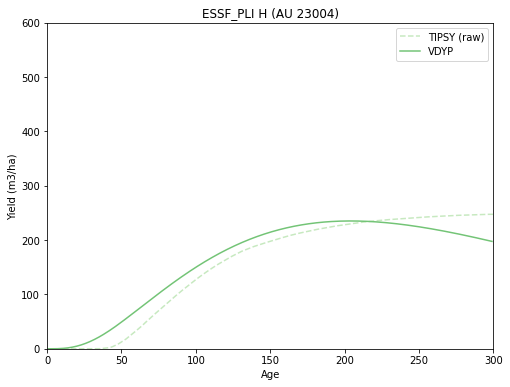

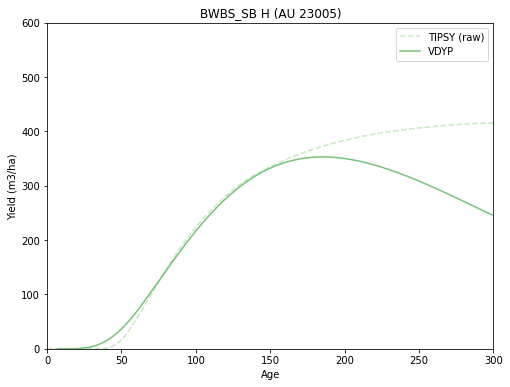

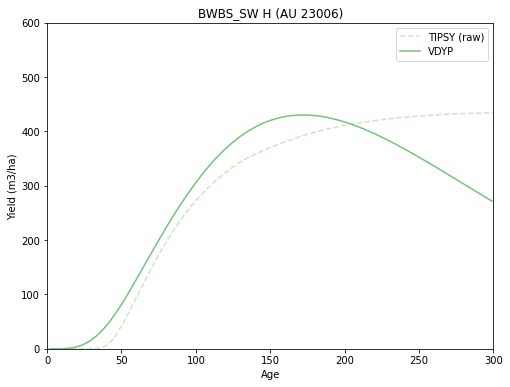

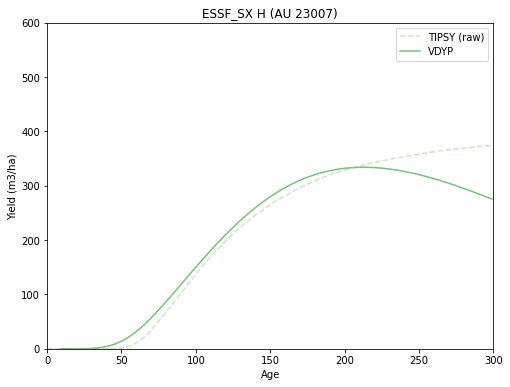

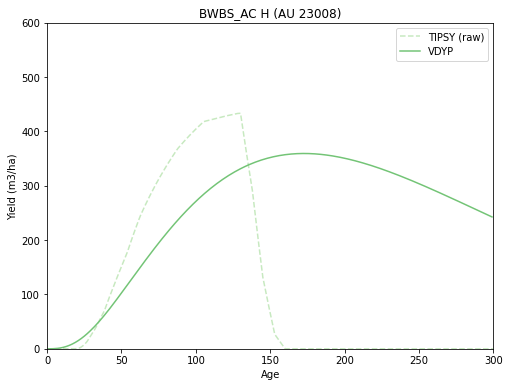

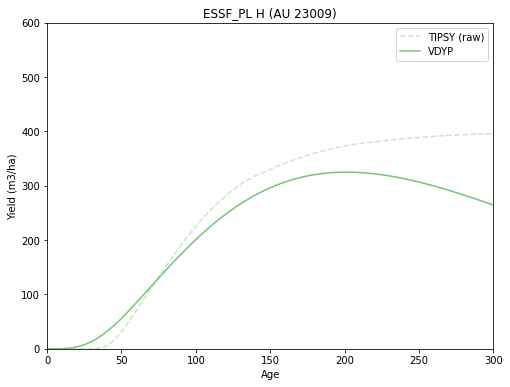

In [31]:
# loop over tsas here and run notebook 01_run-tsa_step2
for tsa in ria_tsas[:]:
    %run 01b_run-tsa.ipynb

Done.

# Export curves to CSV data tables (for soft-link to `spadesCBM`)

Failed attempt to automate translating VRI species codes to CANFI species codes. Could potentially work later, if the `LandR_sppEquivalencies.csv` data table was set up correctly to allow this. 

In [32]:
if 0:
    spp_map = pd.read_csv('./data/LandR_sppEquivalencies.csv')
    spp_map = spp_map[(~spp_map['LANDIS_traits'].isnull()) & (~spp_map['BC_Forestry'].isnull())][['BC_Forestry', 'LANDIS_traits']]
    spp_map['vri'] = spp_map['BC_Forestry'].str.upper()
    spp_map['link'] = spp_map['LANDIS_traits']
    canfi = pd.read_csv('./data/canfi_species.csv')
    canfi['link'] = canfi.genus + '.' + canfi.species
    canfi = canfi.set_index('link').merge(spp_map[['link', 'vri']], on='link', how='left')
    canfi = canfi[~canfi.vri.isnull()].set_index('vri')

Define a dict mapping VRI species codes to CANFI species codes (`spadesCBM` uses CANFI species codes), and a function that returns CANFI code for leading species given a stratum code.

In [33]:
canfi_map = {'AC':1211, 
             'AT':1201, 
             'BL':304, 
             'EP':1303, 
             'FDI':500, 
             'HW':402, 
             'PL':204, 
             'PLI':204, 
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'S':100}

In [34]:
def canfi_species(stratum_code):
    s = stratum_code.split('_')[-1].split('+')[0]
    result = canfi_map[s]
    return result

Define some empty data structures to store output, and compile three data tables that will be used to import yield curve data into `spadesCBM`.

In [35]:
au_table_data = {'au_id':[],
                 'tsa':[],
                 'stratum_code':[],
                 'si_level':[],
                 'canfi_species':[],
                 'unmanaged_curve_id':[],
                 'managed_curve_id':[]} 

curve_table_data = {'curve_id':[],
                    'curve_type':[]}

curve_points_table_data = {'curve_id':[],
                           'x':[],
                           'y':[]}

for tsa in ria_tsas:
    print(tsa)
    vdyp_curves_ = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level'])
    tipsy_curves_ = tipsy_curves[tsa].reset_index().set_index('AU')
    for stratum_code, si_level in list(vdyp_curves_.index.unique()):
        au_id_ = scsi_au[tsa][(stratum_code, si_level)]
        tipsy_curve_id = 20000 + au_id_
        is_managed_au = tipsy_curve_id in tipsy_curves_.index.unique()
        au_id = 100000 * int(tsa) + au_id_
        unmanaged_curve_id = au_id
        managed_curve_id = au_id + 20000 if is_managed_au else unmanaged_curve_id
        #print(au_id, stratum_code, si_level, is_managed_au, unmanaged_curve_id, managed_curve_id)
        au_table_data['au_id'].append(au_id)
        au_table_data['tsa'].append(tsa)
        au_table_data['stratum_code'].append(stratum_code)
        au_table_data['si_level'].append(si_level)
        au_table_data['canfi_species'].append(canfi_species(stratum_code))
        au_table_data['unmanaged_curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_type'].append('unmanaged')
        vdyp_curve = vdyp_curves_.loc[(stratum_code, si_level)]
        #print('vdyp curve')
        for x, y in zip(vdyp_curve.age, vdyp_curve.volume):
            #print(x, round(y, 2))
            curve_points_table_data['curve_id'].append(unmanaged_curve_id)
            curve_points_table_data['x'].append(int(x))
            curve_points_table_data['y'].append(round(y, 2))
        au_table_data['managed_curve_id'].append(managed_curve_id)
        if is_managed_au:
            curve_table_data['curve_id'].append(managed_curve_id)
            curve_table_data['curve_type'].append('managed')        
            tipsy_curve = tipsy_curves_.loc[tipsy_curve_id]
            #print('tipsy curve')
            for x, y in zip(tipsy_curve.Age, tipsy_curve.Yield):
                #print(x, round(y, 2))
                curve_points_table_data['curve_id'].append(managed_curve_id)
                curve_points_table_data['x'].append(int(x))
                curve_points_table_data['y'].append(round(y, 2))
au_table = pd.DataFrame(au_table_data)
curve_table = pd.DataFrame(curve_table_data)
curve_points_table = pd.DataFrame(curve_points_table_data)

08
16
24


40
41


Display the first few lines of each table (quick sanity check).

In [36]:
au_table.head()

,au_id,tsa,stratum_code,si_level,canfi_species,unmanaged_curve_id,managed_curve_id
0,801000,08,BWBS_SB,L,101,801000,801000
1,802000,08,BWBS_SB,M,101,802000,802000
2,803000,08,BWBS_SB,H,101,803000,803000
3,801001,08,BWBS_AT,L,1201,801001,801001
4,802001,08,BWBS_AT,M,1201,802001,802001


In [37]:
curve_table.head()

,curve_id,curve_type
0,801000,unmanaged
1,802000,unmanaged
2,803000,unmanaged
3,801001,unmanaged
4,802001,unmanaged


In [38]:
curve_points_table.head()

,curve_id,x,y
0,801000,31,0.0
1,801000,32,0.0
2,801000,33,0.0
3,801000,34,0.0
4,801000,35,0.0


Export tables to CSV for soft-link with `spadesCBM`.

In [39]:
au_table.to_csv('./data/spadescbm_bundle/au_table.csv')
curve_table.to_csv('./data/spadescbm_bundle/curve_table.csv')
curve_points_table.to_csv('./data/spadescbm_bundle/curve_points_table.csv')

# Impute THLB status to VRI stands

In this next section we impute timber harvesting landbase (THLB) status to the VRI stands. 

The process may seem very complex (because it is), however this is to _only_ (therefore simplest) procedure we were able to develop that comes close to matching TSA-wise THLB area reported in timber supply review (TSR) documentation published on the BC government web site.

If we had access to the original inventory datasets used in the TSR process, we could potentially just lift the THLB attribute from that. Alternatively, we could potentially rebuild the THLB "from the ground up" for each TSA by attempting to replicate THLB netdown documented in TSR documentation (neither trivial nor guaranteed to yield the "correct" THLB area).

Our method may be a bit messy, but it is robust insofar as we were able to get it to work for five TSAs (albeit with quite a bit of trial-and-error parameter tuning for certain TSAs).

Restore the VRI dataset from checkpoint 1, and filter records to include only the forested features to which we want to impute an AU and managment status.

In [40]:
f = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

We found a [THLB raster data layer]:(https://www.hectaresbc.org/app/habc/HaBC.html?type=raster&query=misc.thlb) on the [Hectares BC]:(https://hectaresbc.ca/app/habc/HaBC.html) web site (1 ha pixels). This website is maintained by the BC government (so we assume that data made available there is legitimate), however there is no metadata provided with the THLB raster data layer (so we cannot confirm the date it was compile, author, methodology, etc).

The first step in the process is to calculate stand-wise mean THLB (by masking the THLB raster data layer with stand polygons to extract the relevant pixels, and calculating mean value of all pixels with non-null values), and store the result in the `thlb_raw` field in the inventory dataframe. Note that THLB raster pixels.

Note that non-null data values in the THLB raster layer are in the range $[0, 100]$, which we are assuming as "percent attribution to THLB status". THLB should logically be a binary variable (not a percent), seeing as stands either are or are not eligible for harvesting. Perhaps the raster data is recompiled from a binary THLB attribute in a high-resolution polygon data layer with small sub-pixel areas netted out of THLB for various reasons (impossible to say from limited metadata). In later steps, we need to coerce this into a stand-wise binary THLB attribute to be compatible with `spades_ws3` module downstream.

Extract from THLB raster layer metadata follows, in case this helps track down some of the missing answers later.

<blockquote>
    
Description
The timber harvesting land base (THLB) is defined for timber supply analysis. The THLB is Crown forest land where timber harvesting is considered acceptable and economically feasible given objectives for all relevant forest values, existing timber quality, market values and available technology. It approximates the areas on which timber harvesting can reasonably be expected or extrapolated given existing forest management objectives and practices. The THLB is not meant to be a legally-defined or geographically static entity.

Creator / Publisher
Ministry of Forests and Range, Forest Analysis and Inventory Branch

Contact
Doug Layden (Doug.Layden@gov.bc.ca, Timber Supply Analyst, Ministry of Forests and Range, Forest Analysis and Inventory Branch

Load Date
April 13, 2011

Coverage
Timber Supply Areas. Not Tree Farm Licences.
</blockquote>

In [ ]:
with rio.open('./data/misc.thlb.tif') as src:
    def mean_thlb(r):
        try:
            a, _ = mask(src, r.geometry, crop=True)
        except:
            return 0
        return np.mean(a[a >= 0])
    f['thlb_raw'] = f.swifter.apply(mean_thlb, axis=1)

Pandas Apply:   0%|          | 0/1990024 [00:00<?, ?it/s]

This is from an earlier (failed) attempt to impute a binary THLB attribute to VRI data directly from a data layer from a previous (PICS BC forest carbon) project. No dice (runs, but resulting TSA-wise THLB area does not match THLB area reported in TSR documentation).

In [ ]:
if 0:
    thlb_rasterprop_thresh = 0.01
    with rio.open('./data/ria_demo/ria_landscapestack_init.tif') as src:
        def is_thlb(r):
            try:
                a, _ = mask(src, r.geometry, crop=True)
            except:
                return 0
            aa = a[1]
            return 1 if np.mean(aa[aa >= 0]) > thlb_rasterprop_thresh else 0
        f['thlb'] = f.swifter.apply(is_thlb, axis=1)

Filter VRI data.

In [ ]:
if 1:
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[~f.SPECIES_CD_1.isnull()]
    f = f[~f.BCLCS_LEVEL_5.isnull()]
    f = f[~f.SITE_INDEX.isnull()]

Check row and column count.

In [ ]:
f.shape

Compile standard and lexmatch stratum fields.

In [ ]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

In [ ]:
f.to_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [ ]:
if 0:
    f = pd.read_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [ ]:
stratum_col = 'stratum'
f['%s_matched' % stratum_col] = None

In [ ]:
if 0:
    au_table = pd.read_csv('./data/spadescbm_bundle/au_table.csv')
    curve_table = pd.read_csv('./data/spadescbm_bundle/curve_table.csv')
    curve_points_table = pd.read_csv('./data/spadescbm_bundle/curve_points_table.csv')
    au_table['tsa'] = au_table.apply(lambda r: '%02d' % r.tsa, axis=1
                                )

Compile `stratum_matched` column.

For stands in one of the compiled strata in each TSA (and filtered records that happen to have a stratum code in the list of compiled strata), we just use that stratum code (easy peasy). For the remaining records, we use the "best match" stratum code (which we derive from a lexicographic analysis that defines best match based on minimum Levenstein distance between the "lexmatch" versions of the stratum codes).   

In [ ]:
for tsa in ria_tsas:    
    print('matching tsa', tsa)
    try:
        f.reset_index(inplace=True)
    except:
        pass
    stratum_codes = list(au_table.set_index('tsa').loc[tsa].stratum_code.unique())
    f_ = f.set_index('tsa_code').loc[tsa].set_index('stratum')
    totalarea = f_.FEATURE_AREA_SQM.sum()
    f_['totalarea_p'] = f_.FEATURE_AREA_SQM / totalarea
    names1 = set(f_.loc[stratum_codes].stratum_lexmatch.unique())
    names2 = set(f_.stratum_lexmatch.unique()) - names1
    stratum_key = f_.reset_index().groupby('%s_lexmatch' % stratum_col)[stratum_col].first()
    totalarea_p_sum__ = f_.groupby('%s_lexmatch' % stratum_col).totalarea_p.sum()
    lev_dist = {n2:{n1:distance.levenshtein(n1, n2) for n1 in names1} for n2 in names2}
    lev_dist_low = {n2:{n1:(lev_dist[n2][n1], totalarea_p_sum__.loc[n1]) 
                        for n1 in lev_dist[n2].keys() if lev_dist[n2][n1] == min(lev_dist[n2].values())} 
                    for n2 in names2}
    bm = {stratum_key.loc[n2]:stratum_key[max(lev_dist_low[n2].items(), key=operator.itemgetter(1))[0]] for n2 in names2}
    f_.reset_index(inplace=True)
    c, sc = stratum_col, stratum_codes
    f_['%s_matched' % stratum_col] = f_.swifter.apply(lambda r: r[c] if r[c] in sc else bm[r[c]], axis=1)
    
    m = f[['FEATURE_ID']].merge(f_[['FEATURE_ID', 'stratum_matched']], on='FEATURE_ID', how='left').set_index('FEATURE_ID')
    f.set_index('FEATURE_ID', inplace=True)
    f['stratum_matched'] = m.stratum_matched.where(~m.stratum_matched.isnull(), 
                                                   f.stratum_matched)

Compile a dataframe of stratum-wise site index (SI) statistics, and then use this to assign `si_level` (H, M, L) attribute to each stand, based on stratum-level SI quantiles.

In [ ]:
stratum_si_stats = f.groupby('stratum_matched').SITE_INDEX.describe(percentiles=[0, 0.05, 0.20, 0.35, 0.5, 0.65, 0.80, 0.95, 1])
#si_levelquants={'L':[5, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 95]}
si_levelquants={'L':[0, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 100]}

In [ ]:
for stratum_code in stratum_si_stats.index:
    print(stratum_code)
    for i, (si_level, Q) in enumerate(si_levelquants.items()):        
        si_lo = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[0]]
        si_md = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[1]]
        si_hi = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[2]] 
        f.loc[(f.stratum_matched == stratum_code) & (f.SITE_INDEX >= si_lo) & (f.SITE_INDEX <= si_hi), 'si_level'] = si_level

Assign an AU identifier code to each inventory record.

In [ ]:
def au_from_scsi(r):
    try:
        au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
        return au_id
    except:
        return None

In [ ]:
f['au'] = f.swifter.apply(au_from_scsi, axis=1)

Check dataframe shape.

In [ ]:
f.shape

Filter out records with null AU.

In [ ]:
f = f[~f.au.isnull()]

Check dataframe shape.

In [ ]:
f.shape

Serialize dataframe to feather file.

In [ ]:
f.to_feather(ria_vri_vclr1p_checkpoint6_feather_path)

In [ ]:
try:
    au_table.set_index('au_id', inplace=True)
except:
    pass

Compile two new columns assigning a yield curve ID to each inventory record. 

`curve1` uses managed (TIPSY) curves if applicable (i.e., if age is 60 or less and has a managed yield curve defined). 
`curve2` only uses unmanaged (VDYP) yield curves.

In [ ]:
def assign_curve1(r):
    # age=60 managed/unmanaged cutoff assumption from Cosmin Man (personal communication)
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    if r.PROJ_AGE_1 <= 60 and not np.isnan(au['managed_curve_id']):
        curve_id = au['managed_curve_id']
    else:
        curve_id = au['unmanaged_curve_id']
    return int(curve_id)

In [ ]:
f['curve1'] = f.swifter.apply(assign_curve1, axis=1)

In [ ]:
def assign_curve2(r):
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    return au['unmanaged_curve_id']

In [ ]:
f['curve2'] = f.swifter.apply(assign_curve2, axis=1)

In [ ]:
f.to_feather(ria_vri_vclr1p_checkpoint7_feather_path)

In [ ]:
if 1:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint7_feather_path) 

In [ ]:
f.thlb_raw.describe()

In [ ]:
f.thlb_raw.hist()

In [ ]:
f.reset_index(inplace=True)

In [ ]:
def thlb_area(r):
    if r.tsa_code == '08':
        if r.thlb_raw < 90: 
            return 0.
        if r.SPECIES_CD_1 in species_spruce and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in species_pine and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_aspen and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_fir and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in ('SB', 'E', 'EA', 'EB', 'LT'):
            return 0
    return r.thlb_raw * r.FEATURE_AREA_SQM * 0.000001 

In [ ]:
f['thlb_area'] = f.swifter.apply(thlb_area, axis=1)

In [ ]:
def assign_thlb(r):
    thlb_thresh = 50
    if r.tsa_code == '08':
        thlb_thresh = 93
    elif r.tsa_code == '24':
        thlb_thresh = 69
    return 1 if r.thlb_raw > thlb_thresh else 0

In [ ]:
f['thlb'] = f.swifter.apply(assign_thlb, axis=1)

In [ ]:
f.query('thlb == 1').groupby('tsa_code').FEATURE_AREA_SQM.sum() * 0.0001 

In [ ]:
f.groupby('tsa_code').thlb_area.sum() 

In [ ]:
def has_managed_curve(r):
    if r.thlb == 0: 
        return -1
    else:
        if np.isnan(au_table.loc[int(r.au)].managed_curve_id):
            return 0
        else:
            return 1

In [ ]:
f.to_feather(ria_vri_vclr1p_checkpoint8_feather_path)

In [ ]:
if 0:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint8_feather_path) 

In [ ]:
if 0:
    f.to_file('./data/ria_vri-final.shp')
    !zip ./data/ria_vri-final_shp.zip ./data/ria_vri-final.*
    !mv ./data/ria_vri-final_shp.zip ./data/spadescbm_bundle/
    !zip -r ./data/spadescbm_bundle.zip ./data/spadescbm_bundle

In [ ]:
def clean_geometry(r):
    from shapely.geometry import MultiPolygon
    g = r.geometry
    if not g.is_valid:
        _g = g.buffer(0)
        ################################
        # HACK
        # Something changed (maybe in fiona?) and now all GDB datasets are
        # loading as MultiPolygon geometry type (instead of Polygon). 
        # The buffer(0) trick smashes the geometry back to Polygon, 
        # so this hack upcasts it back to MultiPolygon.
        # 
        # Not sure how robust this is going to be (guessing not robust).
        _g = MultiPolygon([_g])
        assert _g.is_valid
        assert _g.geom_type == 'MultiPolygon'
        g = _g
    return g

In [ ]:
def extract_features(f, tsa):
    f_ = f[['geometry', 'tsa_code', 'thlb', 'au', 'curve1', 'curve2', 'SPECIES_CD_1', 'PROJ_AGE_1', 'FEATURE_AREA_SQM']]
    f_ = f_.set_index('tsa_code').loc[tsa].reset_index()
    f_.geometry = f_.swifter.apply(clean_geometry, axis=1)
    return f_

In [ ]:
#prop_names = [u'tsa_code', u'thlb', u'au', u'SPECIES_CD_1', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_names = [u'tsa_code', u'thlb', u'au', u'canfi_species', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_types = [(u'theme0', 'str:10'),
              (u'theme1', 'str:1'),
              (u'theme2', 'str:10'), 
              (u'theme3', 'str:5'), 
              (u'age', 'int:5'), 
              (u'area', 'float:10.1')]

In [ ]:
columns = dict(zip(prop_names, dict(prop_types).keys()))

In [ ]:
import os
for tsa in ria_tsas[:]:
    print('processing tsa', tsa)
    f_ = extract_features(f, tsa)
    try:
        os.mkdir('./data/shp/tsa%s.shp' % tsa)
    except:
        pass
    f_.rename(columns=columns, inplace=True)
    f_.theme0 = 'tsa' + f_.theme0
    f_.theme2 = f_.theme2.astype(int)
    f_.theme3 = f_.apply(lambda r: au_table.loc[r.au].canfi_species, axis=1)
    f_.age = f_.age.fillna(0)
    f_.age = f_.age.astype(int)
    f_.area = (f_.area * 0.0001).round(1)
    f_.to_file('./data/shp/tsa%s.shp/stands.shp' % tsa)